In [109]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from sqlalchemy import create_engine
import statistics
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score

In [110]:
import warnings
warnings.filterwarnings('ignore')

## Load Data From Database

In [6]:
database_name = 'telecom'
table_name= 'xdr_data'

connection_params = { "host": "localhost", "user": "postgres", "password": "root",
                    "port": "5432", "database": "telecom"}

engine = create_engine(f"postgresql+psycopg2://{connection_params['user']}:{connection_params['password']}@{connection_params['host']}:{connection_params['port']}/{connection_params['database']}")

# str or SQLAlchemy Selectable (select or text object)
sql_query = 'SELECT * FROM xdr_data'

df = pd.read_sql(sql_query, con= engine)

## Filling Missing Categorical Data

In [7]:
category_data = df[['Start','End','Last Location Name', 'Handset Manufacturer','Handset Type']]
# fill 'race' column with mode
#category_data['Start'] = category_data['Start'].fillna(category_data['Start'].mode()[0])
category_data['Start'] = category_data['Start'].fillna(category_data['Start'].mode()[0])
category_data['End'] = category_data['End'].fillna(category_data['End'].mode()[0])
category_data['Last Location Name'] = category_data['Last Location Name'].fillna(category_data['Last Location Name'].mode()[0])
category_data['Handset Manufacturer'] = category_data['Handset Manufacturer'].fillna(category_data['Handset Manufacturer'].mode()[0])
category_data['Handset Type'] = category_data['Handset Type'].fillna(category_data['Handset Type'].mode()[0])


In [8]:
category_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 150001 entries, 0 to 150000
Data columns (total 5 columns):
 #   Column                Non-Null Count   Dtype 
---  ------                --------------   ----- 
 0   Start                 150001 non-null  object
 1   End                   150001 non-null  object
 2   Last Location Name    150001 non-null  object
 3   Handset Manufacturer  150001 non-null  object
 4   Handset Type          150001 non-null  object
dtypes: object(5)
memory usage: 5.7+ MB


## Filling Missing Numerical Data

In [9]:
df_fill = df.drop(['Start','End','Last Location Name', 'Handset Manufacturer','Handset Type'], axis=1)
#df_fill.head()

In [10]:
# Convert columns to numeric, coercing errors to NaN
numeric_df = df_fill.apply(pd.to_numeric, errors='coerce')

# Calculate the mean of each column
mean_values = numeric_df.mean()

# Fill missing values with the mean of each column
filled_data_frame = numeric_df.fillna(mean_values)


In [13]:
filled_data_frame.head()

Bearer Id  Start ms  End ms  Dur. (ms)          IMSI  MSISDN/Number  \
0  1.311448e+19     770.0   662.0  1823652.0  2.082014e+14   3.366496e+10   
1  1.311448e+19     235.0   606.0  1365104.0  2.082019e+14   3.368185e+10   
2  1.311448e+19       1.0   652.0  1361762.0  2.082003e+14   3.376063e+10   
3  1.311448e+19     486.0   171.0  1321509.0  2.082014e+14   3.375034e+10   
4  1.311448e+19     565.0   954.0  1089009.0  2.082014e+14   3.369980e+10   

           IMEI  Avg RTT DL (ms)  Avg RTT UL (ms)  Avg Bearer TP DL (kbps)  \
0  3.552121e+13        42.000000         5.000000                     23.0   
1  3.579401e+13        65.000000         5.000000                     16.0   
2  3.528151e+13       109.795706        17.662883                      6.0   
3  3.535661e+13       109.795706        17.662883                     44.0   
4  3.540701e+13       109.795706        17.662883                      6.0   

   ...  Youtube DL (Bytes)  Youtube UL (Bytes)  Netflix DL (Bytes)  \
0  ...          15854611.0           2501332.0           8198936.0   
1  ...          20247395.0          19111729.0          18338413.0   
2  ...          19725661.0          14699576.0          17587794.0   
3  ...          21388122.0          15146643.0          13994646.0   
4  ...          15259380.0          18962873.0          17124581.0   

   Netflix UL (Bytes)  Gaming DL (Bytes)  Gaming UL (Bytes)  Other DL (Bytes)  \
0           9656251.0        278082303.0         14344150.0       171744450.0   
1          17227132.0        608750074.0          1170709.0       526904238.0   
2           6163408.0        229584621.0           395630.0       410692588.0   
3           1097942.0        799538153.0         10849722.0       749039933.0   
4            415218.0        527707248.0          3529801.0       550709500.0   

   Other UL (Bytes)  Total UL (Bytes)  Total DL (Bytes)  
0         8814393.0        36749741.0       308879636.0  
1        15055145.0        53800391.0       653384965.0  
2         4215763.0        27883638.0       279807335.0  
3        12797283.0        43324218.0       846028530.0  
4        13910322.0        38542814.0       569138589.0  

[5 rows x 40 columns]

## Dropping a feature with more than 70000 missing value

In [11]:
#Drop a feature with more than 70000 missing Values
df_fill = df_fill.drop(['Nb of sec with 125000B < Vol DL', 'Nb of sec with 1250B < Vol UL < 6250B','Nb of sec with 31250B < Vol DL < 125000B',
    'Nb of sec with 37500B < Vol UL','Nb of sec with 6250B < Vol DL < 31250B','Nb of sec with 6250B < Vol UL < 37500B','TCP DL Retrans. Vol (Bytes)',
    'TCP UL Retrans. Vol (Bytes)','HTTP DL (Bytes)','HTTP UL (Bytes)'], axis=1) 

## Concatenate Both cleaned categorical and Numerical dataframe

In [18]:
df_clean = pd.concat([filled_data_frame, category_data], axis=1, join="inner")

In [17]:
df_clean.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 150001 entries, 0 to 150000
Data columns (total 45 columns):
 #   Column                          Non-Null Count   Dtype  
---  ------                          --------------   -----  
 0   Bearer Id                       150001 non-null  float64
 1   Start ms                        150001 non-null  float64
 2   End ms                          150001 non-null  float64
 3   Dur. (ms)                       150001 non-null  float64
 4   IMSI                            150001 non-null  float64
 5   MSISDN/Number                   150001 non-null  float64
 6   IMEI                            150001 non-null  float64
 7   Avg RTT DL (ms)                 150001 non-null  float64
 8   Avg RTT UL (ms)                 150001 non-null  float64
 9   Avg Bearer TP DL (kbps)         150001 non-null  float64
 10  Avg Bearer TP UL (kbps)         150001 non-null  float64
 11  DL TP < 50 Kbps (%)             150001 non-null  float64
 12  50 Kbps < DL TP 

## Descriptive statistics for quantitative variables

In [11]:
# Descriptive statistics for quantitative variables
desc_stats = df_clean.describe()

# Display basic metrics (mean, median, etc.)
print("\nBasic Metrics:")
desc_stats


Basic Metrics:


Bearer Id       Start ms         End ms     Dur. (ms)          IMSI  \
count  1.500010e+05  150001.000000  150001.000000  1.500010e+05  1.500010e+05   
mean   1.013887e+19     499.188200     498.800880  1.046086e+05  2.082016e+14   
std    2.883600e+18     288.610872     288.096693  8.103735e+04  2.144722e+10   
min    6.917538e+18       0.000000       0.000000  7.142000e+03  2.040471e+14   
25%    7.349883e+18     250.000000     251.000000  5.744200e+04  2.082014e+14   
50%    7.349883e+18     499.000000     500.000000  8.639900e+04  2.082015e+14   
75%    1.304243e+19     749.000000     750.000000  1.324300e+05  2.082018e+14   
max    1.318654e+19     999.000000     999.000000  1.859336e+06  2.140743e+14   

       MSISDN/Number          IMEI  Avg RTT DL (ms)  Avg RTT UL (ms)  \
count   1.500010e+05  1.500010e+05    150001.000000    150001.000000   
mean    4.188282e+10  4.847455e+13       109.795706        17.662883   
std     2.438731e+12  2.237359e+13       559.342620        76.529933   
min     3.360100e+10  4.400152e+11         0.000000         0.000000   
25%     3.365151e+10  3.546261e+13        35.000000         3.000000   
50%     3.366380e+10  3.572241e+13        54.000000         7.000000   
75%     3.368473e+10  8.611970e+13       109.795706        17.662883   
max     8.823971e+14  9.900120e+13     96923.000000      7120.000000   

       Avg Bearer TP DL (kbps)  ...  Youtube DL (Bytes)  Youtube UL (Bytes)  \
count            150001.000000  ...        1.500010e+05        1.500010e+05   
mean              13300.045927  ...        1.163407e+07        1.100941e+07   
std               23971.798635  ...        6.710569e+06        6.345423e+06   
min                   0.000000  ...        5.300000e+01        1.050000e+02   
25%                  43.000000  ...        5.833501e+06        5.517965e+06   
50%                  63.000000  ...        1.161602e+07        1.101345e+07   
75%               19710.000000  ...        1.744852e+07        1.651556e+07   
max              378160.000000  ...        2.325910e+07        2.201196e+07   

       Netflix DL (Bytes)  Netflix UL (Bytes)  Gaming DL (Bytes)  \
count        1.500010e+05        1.500010e+05       1.500010e+05   
mean         1.162685e+07        1.100175e+07       4.220447e+08   
std          6.725218e+06        6.359490e+06       2.439675e+08   
min          4.200000e+01        3.500000e+01       2.516000e+03   
25%          5.777156e+06        5.475981e+06       2.104733e+08   
50%          1.164222e+07        1.099638e+07       4.234081e+08   
75%          1.747048e+07        1.650727e+07       6.331742e+08   
max          2.325919e+07        2.201196e+07       8.434419e+08   

       Gaming UL (Bytes)  Other DL (Bytes)  Other UL (Bytes)  \
count       1.500010e+05      1.500010e+05      1.500010e+05   
mean        8.288398e+06      4.211005e+08      8.264799e+06   
std         4.782700e+06      2.432050e+08      4.769004e+06   
min         5.900000e+01      3.290000e+03      1.480000e+02   
25%         4.128476e+06      2.101869e+08      4.145943e+06   
50%         8.291208e+06      4.218030e+08      8.267071e+06   
75%         1.243162e+07      6.316918e+08      1.238415e+07   
max         1.655879e+07      8.434425e+08      1.655882e+07   

       Total UL (Bytes)  Total DL (Bytes)  
count      1.500010e+05      1.500010e+05  
mean       4.112121e+07      4.546434e+08  
std        1.127635e+07      2.441421e+08  
min        2.866892e+06      7.114041e+06  
25%        3.322203e+07      2.431072e+08  
50%        4.114324e+07      4.558409e+08  
75%        4.903424e+07      6.657051e+08  
max        7.833131e+07      9.029696e+08  

[8 rows x 40 columns]

## Non-Graphical Univariate Analysis

In [59]:
# Non-Graphical Univariate Analysis
dispersion_params = filled_data_frame.apply(lambda x: statistics.mean(abs(x - x.mean())))
print("\nDispersion Parameters:")
dispersion_params


Dispersion Parameters:


Bearer Id                         2.872357e+18
Start ms                          2.498741e+02
End ms                            2.495715e+02
Dur. (ms)                         5.224859e+04
IMSI                              6.225997e+08
MSISDN/Number                     1.629947e+10
IMEI                              1.939073e+13
Avg RTT DL (ms)                   9.043803e+01
Avg RTT UL (ms)                   1.599548e+01
Avg Bearer TP DL (kbps)           1.737261e+04
Avg Bearer TP UL (kbps)           2.444250e+03
DL TP < 50 Kbps (%)               9.385348e+00
50 Kbps < DL TP < 250 Kbps (%)    4.133155e+00
250 Kbps < DL TP < 1 Mbps (%)     2.476764e+00
DL TP > 1 Mbps (%)                2.476631e+00
UL TP < 10 Kbps (%)               1.937466e+00
10 Kbps < UL TP < 50 Kbps (%)     1.213896e+00
50 Kbps < UL TP < 300 Kbps (%)    2.854474e-01
UL TP > 300 Kbps (%)              1.544268e-01
Activity Duration DL (ms)         2.739012e+06
Activity Duration UL (ms)         2.069269e+06
Dur. (ms).1  

## Graphical Univariate Analysis

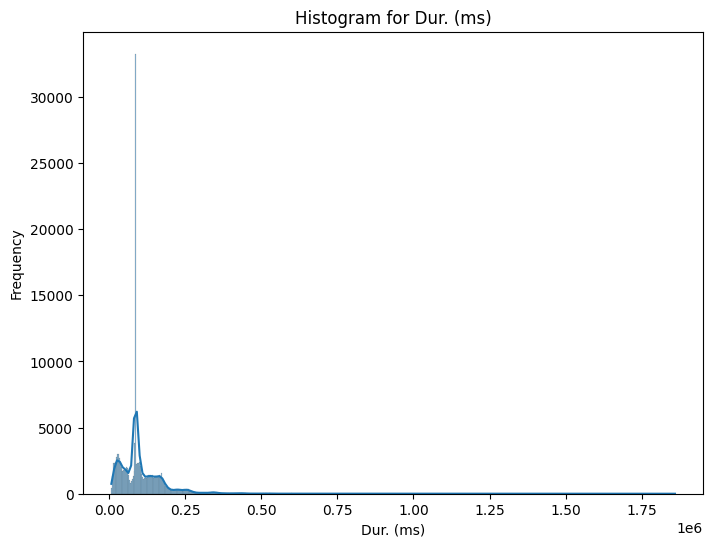

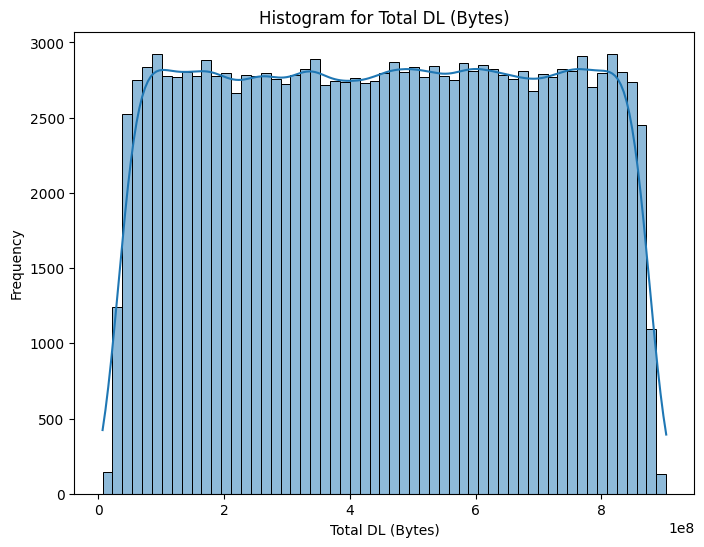

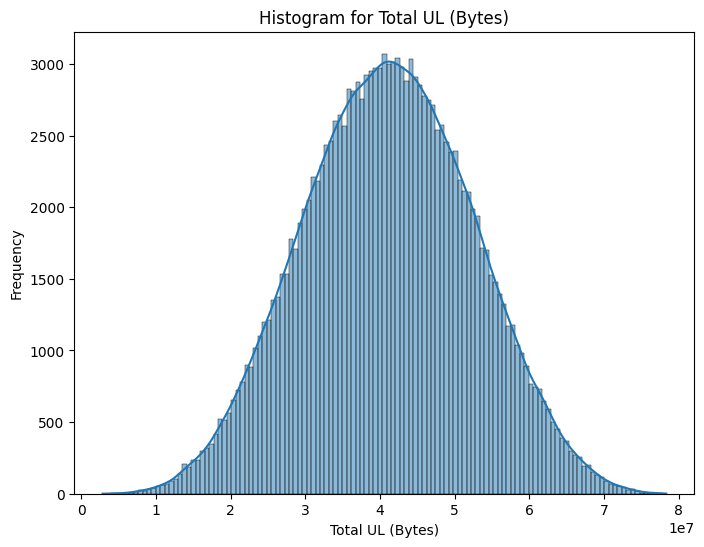

In [61]:
# Graphical Univariate Analysis
# Plotting histograms for selected quantitative variables
quantitative_variables = ['Dur. (ms)', 'Total DL (Bytes)', 'Total UL (Bytes)']
for variable in quantitative_variables:
    plt.figure(figsize=(8, 6))
    sns.histplot(df_clean[variable], kde=True)
    plt.title(f'Histogram for {variable}')
    plt.xlabel(variable)
    plt.ylabel('Frequency')
    plt.show()

## Bivariate Analysis

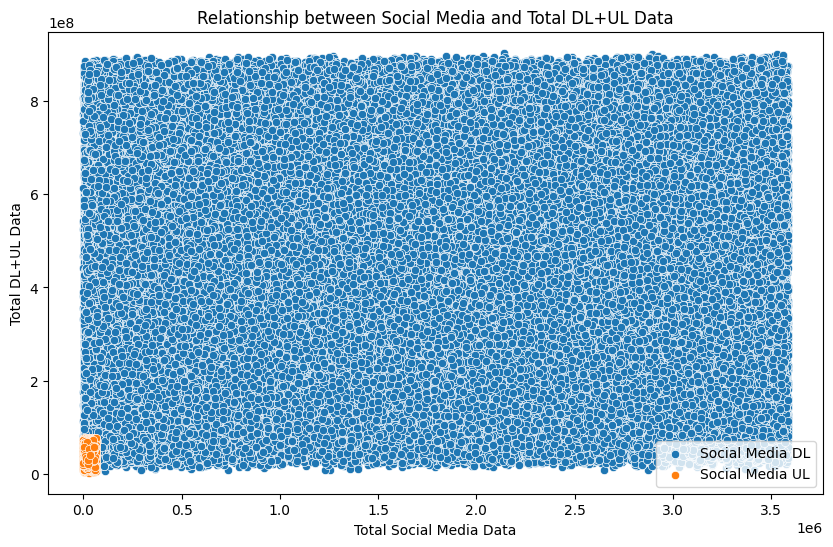

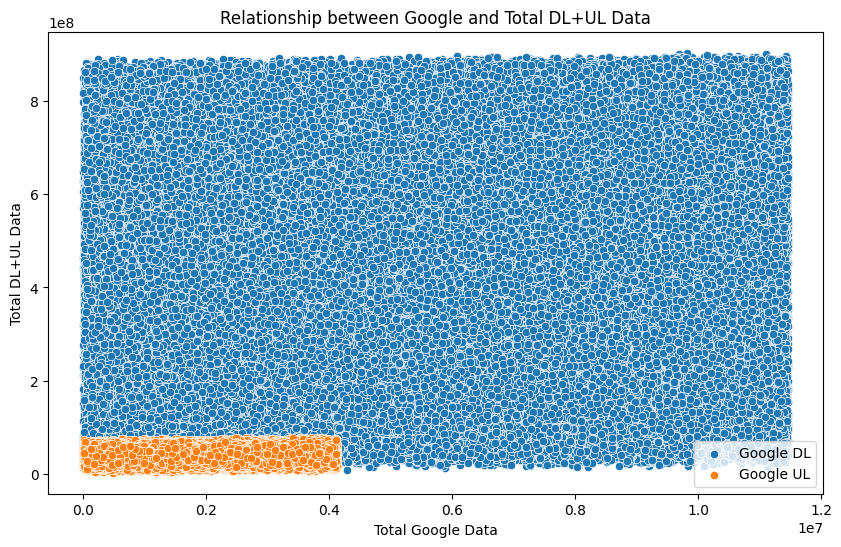

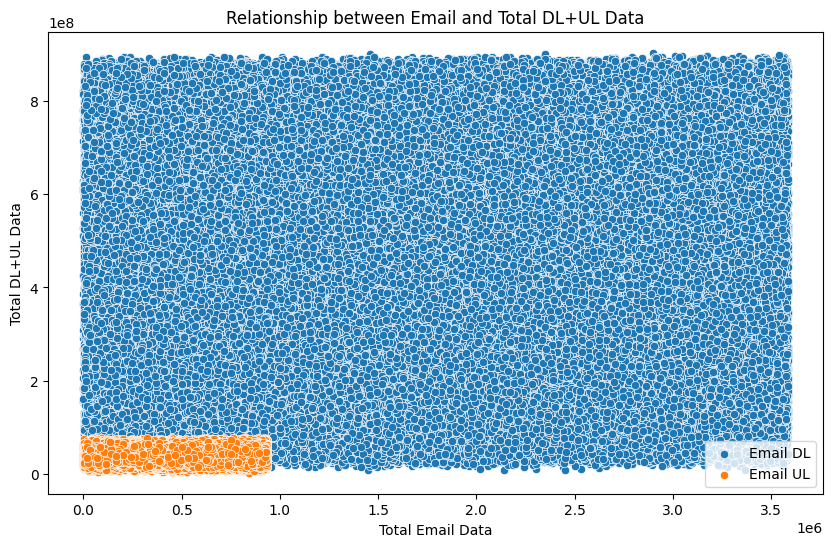

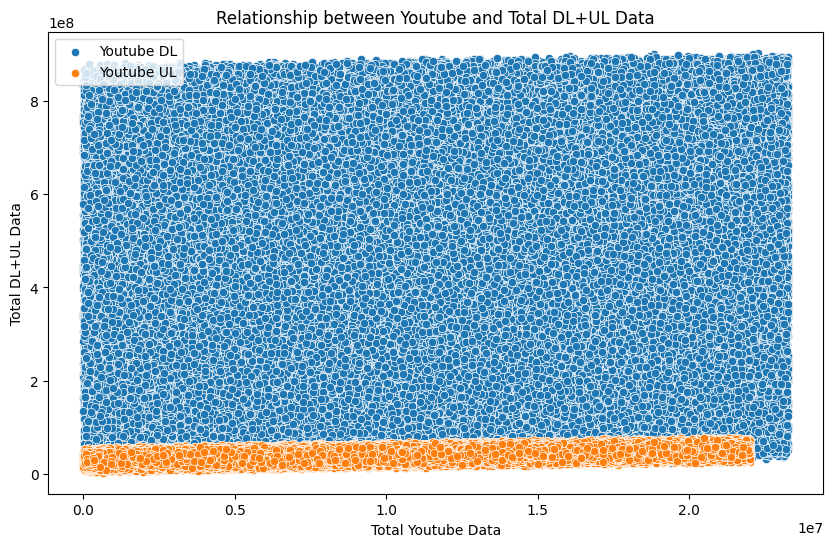

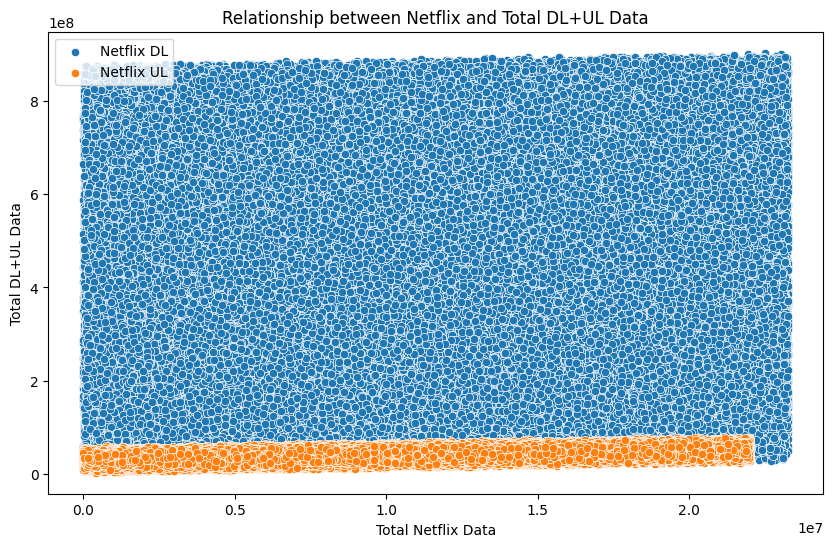

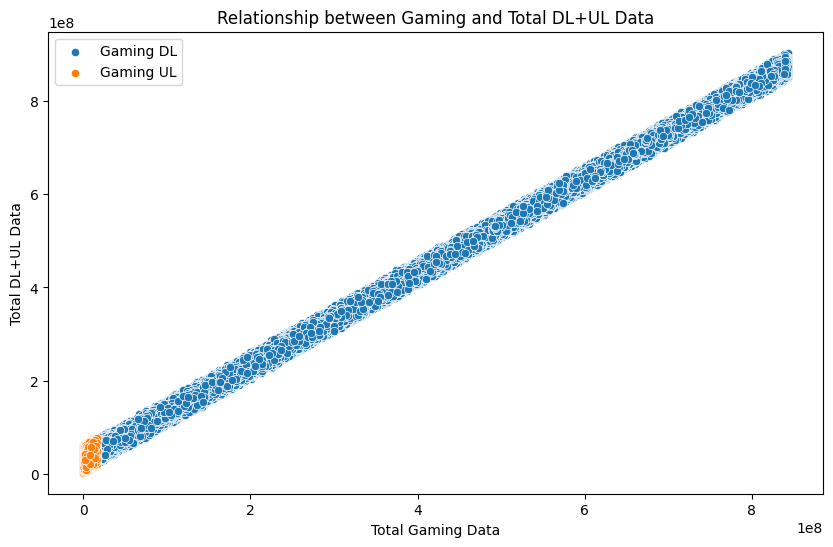

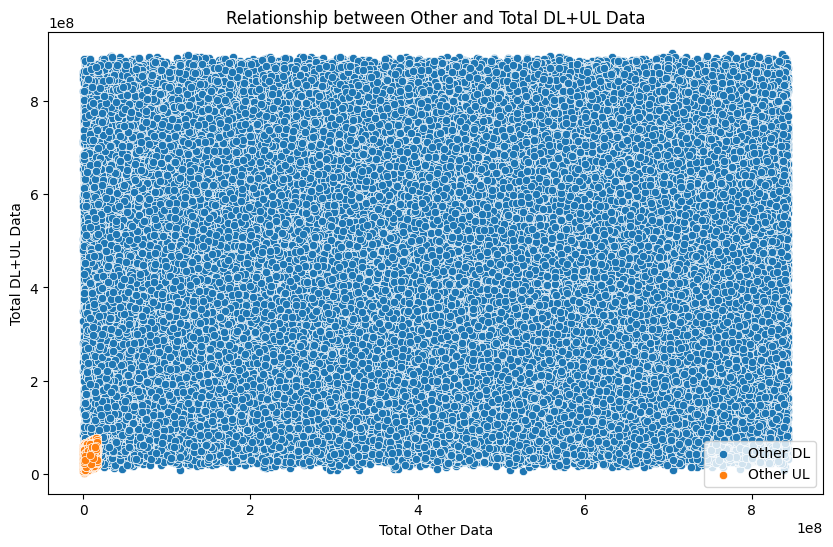

In [62]:
# Bivariate Analysis
# Explore the relationship between each application and total DL+UL data
applications = ['Social Media', 'Google', 'Email', 'Youtube', 'Netflix', 'Gaming', 'Other']

for app in applications:
    plt.figure(figsize=(10, 6))
    sns.scatterplot(x=f'{app} DL (Bytes)', y='Total DL (Bytes)', data=df_clean, label=f'{app} DL')
    sns.scatterplot(x=f'{app} UL (Bytes)', y='Total UL (Bytes)', data=df_clean, label=f'{app} UL')
    plt.title(f'Relationship between {app} and Total DL+UL Data')
    plt.xlabel(f'Total {app} Data')
    plt.ylabel('Total DL+UL Data')
    plt.legend()
    plt.show()

## Top five users decile classes based on the total duration 

In [66]:
#'MSISDN/Number' is the column containing user identifiers
# and 'Dur. (ms)', 'Total DL (Bytes)', and 'Total UL (Bytes)' represent the session duration, download, and upload data
duration_columns = ['Dur. (ms)', 'Total DL (Bytes)', 'Total UL (Bytes)']

# Step 1: Calculate the total duration for each user
df_clean['Total_Duration'] = df_clean[duration_columns].sum(axis=1)

# Step 2: Segment users into deciles based on the total duration
df_clean['Duration_Decile'] = pd.qcut(df_clean['Total_Duration'], q=[0, 0.2, 0.4, 0.6, 0.8, 1], labels=False, precision=0, duplicates='drop')

# Step 3: Compute the total data (DL+UL) for each decile class
decile_data = df_clean.groupby('Duration_Decile')[['Total DL (Bytes)', 'Total UL (Bytes)']].sum().reset_index()

# Display the result
decile_data.head()

Duration_Decile  Total DL (Bytes)  Total UL (Bytes)
0                0      3.491705e+12      1.214366e+12
1                1      8.566163e+12      1.232443e+12
2                2      1.366117e+13      1.232621e+12
3                3      1.870841e+13      1.230574e+12
4                4      2.376952e+13      1.258218e+12

## Task2.2

In [70]:
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler

## correlation matrix

In [67]:
# Compute correlation matrix
correlation_matrix = df_clean[['Social Media DL (Bytes)', 'Google DL (Bytes)', 'Email DL (Bytes)',
                             'Youtube DL (Bytes)', 'Netflix DL (Bytes)', 'Gaming DL (Bytes)', 'Other DL (Bytes)',
                             'Social Media UL (Bytes)', 'Google UL (Bytes)', 'Email UL (Bytes)',
                             'Youtube UL (Bytes)', 'Netflix UL (Bytes)', 'Gaming UL (Bytes)', 'Other UL (Bytes)']].corr()
correlation_matrix

Social Media DL (Bytes)  Google DL (Bytes)  \
Social Media DL (Bytes)                 1.000000          -0.001954   
Google DL (Bytes)                      -0.001954           1.000000   
Email DL (Bytes)                        0.004745          -0.000039   
Youtube DL (Bytes)                     -0.001389           0.001760   
Netflix DL (Bytes)                     -0.001817           0.000548   
Gaming DL (Bytes)                       0.001018          -0.001421   
Other DL (Bytes)                        0.006126          -0.002557   
Social Media UL (Bytes)                -0.000555           0.003542   
Google UL (Bytes)                       0.000186          -0.000103   
Email UL (Bytes)                       -0.002518           0.000742   
Youtube UL (Bytes)                      0.002345           0.000638   
Netflix UL (Bytes)                      0.003457          -0.001569   
Gaming UL (Bytes)                       0.003095          -0.001429   
Other UL (Bytes)                        0.000610          -0.000882   

                         Email DL (Bytes)  Youtube DL (Bytes)  \
Social Media DL (Bytes)          0.004745           -0.001389   
Google DL (Bytes)               -0.000039            0.001760   
Email DL (Bytes)                 1.000000            0.001679   
Youtube DL (Bytes)               0.001679            1.000000   
Netflix DL (Bytes)               0.001351            0.001202   
Gaming DL (Bytes)                0.000050           -0.001861   
Other DL (Bytes)                -0.000444            0.002042   
Social Media UL (Bytes)          0.004823           -0.001786   
Google UL (Bytes)               -0.001157            0.001122   
Email UL (Bytes)                 0.002553           -0.000320   
Youtube UL (Bytes)              -0.004305            0.002433   
Netflix UL (Bytes)              -0.000016            0.001746   
Gaming UL (Bytes)               -0.004335           -0.001893   
Other UL (Bytes)                 0.004675           -0.004830   

                         Netflix DL (Bytes)  Gaming DL (Bytes)  \
Social Media DL (Bytes)           -0.001817           0.001018   
Google DL (Bytes)                  0.000548          -0.001421   
Email DL (Bytes)                   0.001351           0.000050   
Youtube DL (Bytes)                 0.001202          -0.001861   
Netflix DL (Bytes)                 1.000000          -0.003201   
Gaming DL (Bytes)                 -0.003201           1.000000   
Other DL (Bytes)                  -0.006000          -0.002591   
Social Media UL (Bytes)           -0.000772           0.000210   
Google UL (Bytes)                 -0.001288           0.001140   
Email UL (Bytes)                  -0.000011          -0.002519   
Youtube UL (Bytes)                 0.000423          -0.002382   
Netflix UL (Bytes)                 0.001065          -0.001051   
Gaming UL (Bytes)                 -0.000633           0.001162   
Other UL (Bytes)                  -0.002588          -0.001131   

                         Other DL (Bytes)  Social Media UL (Bytes)  \
Social Media DL (Bytes)          0.006126                -0.000555   
Google DL (Bytes)               -0.002557                 0.003542   
Email DL (Bytes)                -0.000444                 0.004823   
Youtube DL (Bytes)               0.002042                -0.001786   
Netflix DL (Bytes)              -0.006000                -0.000772   
Gaming DL (Bytes)               -0.002591                 0.000210   
Other DL (Bytes)                 1.000000                -0.003850   
Social Media UL (Bytes)         -0.003850                 1.000000   
Google UL (Bytes)                0.002097                 0.001085   
Email UL (Bytes)                -0.003805                -0.001427   
Youtube UL (Bytes)               0.002296                -0.002368   
Netflix UL (Bytes)              -0.006691                -0.002493   
Gaming UL (Bytes)               -0.002381                 0.000844   
Other UL (By

# Heatmap of correlation matrix

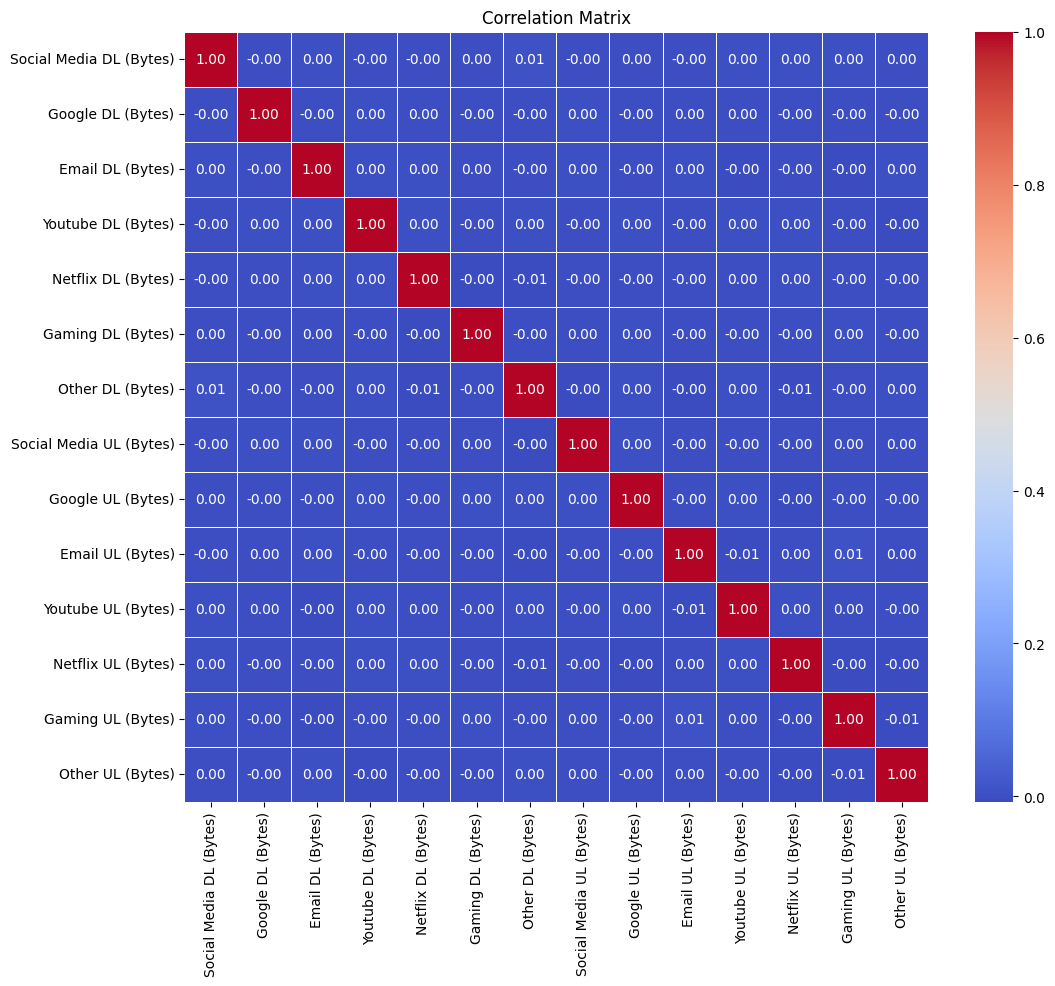

In [23]:
# Create a heatmap
plt.figure(figsize=(12, 10))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', fmt=".2f", linewidths=.5)
plt.title('Correlation Matrix')
plt.show()

## performing a principal component analysis to reduce the dimensions 

In [73]:

correlation_variables = ['Social Media DL (Bytes)', 'Google DL (Bytes)', 'Email DL (Bytes)',
                          'Youtube DL (Bytes)', 'Netflix DL (Bytes)', 'Gaming DL (Bytes)', 'Other DL (Bytes)',
                          'Social Media UL (Bytes)', 'Google UL (Bytes)', 'Email UL (Bytes)',
                          'Youtube UL (Bytes)', 'Netflix UL (Bytes)', 'Gaming UL (Bytes)', 'Other UL (Bytes)']

# Extract the specified variables
data_for_pca = df_clean[correlation_variables]

# Standardize the data (optional, but often recommended for PCA)
standardized_data = (data_for_pca - data_for_pca.mean()) / data_for_pca.std()

# Apply PCA
pca = PCA()
principal_components = pca.fit_transform(standardized_data)

# Create a DataFrame to inspect the principal components
pc_df = pd.DataFrame(data=principal_components, columns=['PC1', 'PC2', 'PC3', 'PC4', 'PC5', 'PC6', 'PC7', 'PC8', 'PC9', 'PC10', 'PC11', 'PC12', 'PC13', 'PC14'])

# Display explained variance ratio
explained_variance_ratio = pca.explained_variance_ratio_
print("Explained Variance Ratio:", explained_variance_ratio)

# Display the first few rows of the principal components DataFrame
pc_df.head()

Explained Variance Ratio: [0.07259283 0.07242906 0.07211392 0.07197411 0.0717675  0.07167547
 0.0715473  0.07137681 0.07118286 0.07108046 0.07091994 0.07059717
 0.07049455 0.07024801]


PC1       PC2       PC3       PC4       PC5       PC6       PC7  \
0  0.510853 -0.743821  0.040788  0.937089  0.087724  0.426210  0.534382   
1 -1.105911  1.290993 -1.831813  0.867038 -0.584565 -1.649853  0.276090   
2  0.510058 -0.038813 -1.769438 -1.123572 -0.615160  1.241044  0.142360   
3 -0.897307  0.197027  0.857810 -1.554121 -1.226982  0.257134  0.888042   
4 -1.080762 -0.562216 -0.821509 -1.750756  0.020072 -0.590865 -0.874372   

        PC8       PC9      PC10      PC11      PC12      PC13      PC14  
0 -0.642663  0.922770  1.376301  0.084401  0.539326 -2.523535 -0.421449  
1  0.102842  1.295938 -0.260151 -0.886426 -1.339781  0.732952  0.272066  
2 -0.096357  0.411901 -0.123778 -0.037030  0.691008  0.917621  1.224648  
3  0.283508  1.645156 -1.147804 -1.691294 -0.581017  0.639074 -0.747087  
4 -0.575659  1.697749  0.528614 -0.906209 -0.086733  0.671325  0.364724

## Task 2.1

## Top 5 Number of xDR Session per user

In [31]:
# Assuming 'MSISDN/Number' is the column containing user identifiers and 'Bearer Id' is used as a session identifier
user_sessions = df_clean.groupby('MSISDN/Number')['Bearer Id'].count().reset_index().sort_values(by=['Bearer Id'], ascending=False)

# Rename the columns for clarity
user_sessions.columns = ['MSISDN/Number', 'Number_of_xDR_sessions']

# Display the result
user_sessions.head()

MSISDN/Number  Number_of_xDR_sessions
106853   4.188282e+10                    1066
13526    3.362632e+10                      18
13180    3.362578e+10                      17
6437     3.361489e+10                      17
37052    3.365973e+10                      16

## Session duration

In [53]:
# Assuming 'MSISDN/Number' is the column containing user identifiers and 'Dur. (ms)' is used as the session duration
user_session_duration = df_clean.groupby('MSISDN/Number')['Dur. (ms)'].sum().reset_index()

# Rename the columns for clarity
user_session_duration.columns = ['MSISDN/Number', 'Total_Session_Duration']

# Display the result
user_session_duration.head()


MSISDN/Number  Total_Session_Duration
0   3.360100e+10                116720.0
1   3.360100e+10                181230.0
2   3.360100e+10                134969.0
3   3.360101e+10                 49878.0
4   3.360101e+10                 37104.0

## Total download (DL) and upload (UL) data

In [34]:
#'MSISDN/Number' is the user identifiers
# and 'Total DL (Bytes)' and 'Total UL (Bytes)' represent the download and upload data
user_total_data = df.groupby('MSISDN/Number')[['Total DL (Bytes)', 'Total UL (Bytes)']].sum().reset_index()

# Rename the columns for clarity
user_total_data.columns = ['MSISDN/Number', 'Total_DL_Data', 'Total_UL_Data']

# Display the result
user_total_data.head()



MSISDN/Number  Total_DL_Data  Total_UL_Data
0   3.360100e+10   8.426375e+08     36053108.0
1   3.360100e+10   1.207552e+08     36104459.0
2   3.360100e+10   5.566597e+08     39306820.0
3   3.360101e+10   4.019932e+08     20327526.0
4   3.360101e+10   1.363130e+09     94280527.0

## Total data volume (in Bytes) during this session for each application

In [54]:
# 'MSISDN/Number' is the column containing user identifiers
# and columns like 'Social Media DL (Bytes)', 'Google DL (Bytes)', etc. represent data volume for each application
applications_columns = ['Social Media DL (Bytes)', 'Google DL (Bytes)', 'Email DL (Bytes)',
                         'Youtube DL (Bytes)', 'Netflix DL (Bytes)', 'Gaming DL (Bytes)', 'Other DL (Bytes)',
                         'Social Media UL (Bytes)', 'Google UL (Bytes)', 'Email UL (Bytes)',
                         'Youtube UL (Bytes)', 'Netflix UL (Bytes)', 'Gaming UL (Bytes)', 'Other UL (Bytes)']

user_application_data = df.groupby('MSISDN/Number')[applications_columns].sum().reset_index()

# Rename the columns for clarity
user_application_data.columns = ['MSISDN/Number'] + [f'Total_{col}_Data' for col in applications_columns]

# Display the result
user_application_data.head()

MSISDN/Number  Total_Social Media DL (Bytes)_Data  \
0   3.360100e+10                           2206504.0   
1   3.360100e+10                           2598548.0   
2   3.360100e+10                           3148004.0   
3   3.360101e+10                            251469.0   
4   3.360101e+10                           2861230.0   

   Total_Google DL (Bytes)_Data  Total_Email DL (Bytes)_Data  \
0                     3337123.0                     837400.0   
1                     4197697.0                    2828821.0   
2                     3343483.0                    2436500.0   
3                     5937765.0                    2178618.0   
4                    13728668.0                    2247808.0   

   Total_Youtube DL (Bytes)_Data  Total_Netflix DL (Bytes)_Data  \
0                     14900201.0                     10265105.0   
1                      5324251.0                       770569.0   
2                      2137272.0                     16525919.0   
3                      4393123.0                      1157362.0   
4                     10339971.0                     24971647.0   

   Total_Gaming DL (Bytes)_Data  Total_Other DL (Bytes)_Data  \
0                  8.110911e+08                  377096990.0   
1                  1.050353e+08                  279557701.0   
2                  5.290685e+08                  495086501.0   
3                  3.880748e+08                   25248001.0   
4                  1.308981e+09                  777643713.0   

   Total_Social Media UL (Bytes)_Data  Total_Google UL (Bytes)_Data  \
0                             25631.0                     1051882.0   
1                             62017.0                     1137166.0   
2                             47619.0                       99643.0   
3                             28825.0                     3740728.0   
4                             51312.0                     4770948.0   

   Total_Email UL (Bytes)_Data  Total_Youtube UL (Bytes)_Data  \
0                     493962.0                      6724347.0   
1                     478960.0                      7107972.0   
2                     768880.0                     19196298.0   
3                     106052.0                      2584198.0   
4                    1057661.0                     31193031.0   

   Total_Netflix UL (Bytes)_Data  Total_Gaming UL (Bytes)_Data  \
0                     16915876.0                     1367528.0   
1                     10451194.0                    14714780.0   
2                      2827981.0                     9759228.0   
3                       784730.0                     3051292.0   
4                     24230077.0                     5816727.0   

   Total_Other UL (Bytes)_Data  
0                    9473882.0  
1                    2152370.0  
2                    6607171.0  
3                   10031701.0  
4                   27160771.0

## Application That used more by User

In [47]:
applications_columns = ['Social Media DL (Bytes)', 'Google DL (Bytes)', 'Email DL (Bytes)',
                         'Youtube DL (Bytes)', 'Netflix DL (Bytes)', 'Gaming DL (Bytes)', 'Other DL (Bytes)',
                         'Social Media UL (Bytes)', 'Google UL (Bytes)', 'Email UL (Bytes)',
                         'Youtube UL (Bytes)', 'Netflix UL (Bytes)', 'Gaming UL (Bytes)', 'Other UL (Bytes)']

# Create a new DataFrame with the total data volume for each application
total_data_per_application = pd.DataFrame({
    'Application': applications_columns,
    'Total_Data_Volume': df_clean[applications_columns].sum()
})

# Find the application with the highest total data volume
most_used_application = total_data_per_application.loc[total_data_per_application['Total_Data_Volume'].idxmax()]

# Display the result
print("Most Used Application:", most_used_application['Application'])
print("Total Data Volume:", most_used_application['Total_Data_Volume'])

Most Used Application: Gaming DL (Bytes)
Total Data Volume: 63307127434008.59


## Application Usage Plot

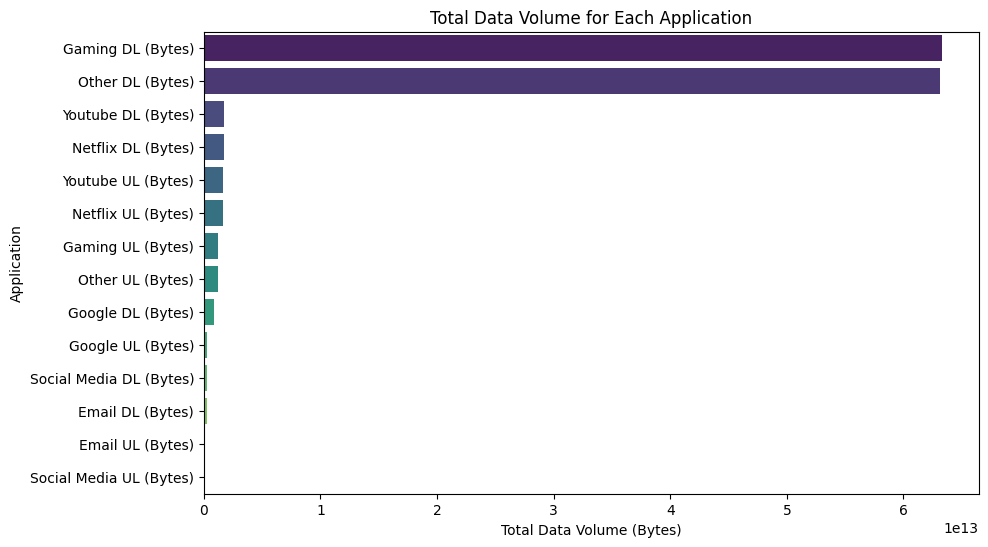

In [48]:
applications_columns = ['Social Media DL (Bytes)', 'Google DL (Bytes)', 'Email DL (Bytes)',
                         'Youtube DL (Bytes)', 'Netflix DL (Bytes)', 'Gaming DL (Bytes)', 'Other DL (Bytes)',
                         'Social Media UL (Bytes)', 'Google UL (Bytes)', 'Email UL (Bytes)',
                         'Youtube UL (Bytes)', 'Netflix UL (Bytes)', 'Gaming UL (Bytes)', 'Other UL (Bytes)']

# Create a new DataFrame with the total data volume for each application
total_data_per_application = pd.DataFrame({
    'Application': applications_columns,
    'Total_Data_Volume': df_clean[applications_columns].sum()
})

# Sort the DataFrame by total data volume in descending order
total_data_per_application = total_data_per_application.sort_values(by='Total_Data_Volume', ascending=False)

# Create a bar plot
plt.figure(figsize=(10, 6))
sns.barplot(x='Total_Data_Volume', y='Application', data=total_data_per_application, palette='viridis')
plt.title('Total Data Volume for Each Application')
plt.xlabel('Total Data Volume (Bytes)')
plt.ylabel('Application')
plt.show()

# Task 3

## sessions frequency 

In [77]:
sessions_df = df_clean[['MSISDN/Number', 'Start', 'End']]

# Convert 'Start' and 'End' columns to datetime format
sessions_df['Start'] = pd.to_datetime(sessions_df['Start'])
sessions_df['End'] = pd.to_datetime(sessions_df['End'])

# Calculate session duration in minutes
sessions_df['Session_Duration_Minutes'] = (sessions_df['End'] - sessions_df['Start']).dt.total_seconds() / 60

# Calculate the number of sessions for each user
session_frequency = sessions_df.groupby('MSISDN/Number')['Start'].count().reset_index()
session_frequency.columns = ['MSISDN/Number', 'Session_Frequency']

# Display the result
session_frequency.head(10)


MSISDN/Number  Session_Frequency
0   3.360100e+10                  1
1   3.360100e+10                  1
2   3.360100e+10                  1
3   3.360101e+10                  1
4   3.360101e+10                  2
5   3.360101e+10                  2
6   3.360101e+10                  2
7   3.360101e+10                  1
8   3.360101e+10                  2
9   3.360102e+10                  1

## Session Duration Distribution

        MSISDN/Number  Session_Duration_Minutes
0        3.366496e+10                   30394.0
1        3.368185e+10                   22751.0
2        3.376063e+10                   22696.0
3        3.375034e+10                   22025.0
4        3.369980e+10                   18150.0
...               ...                       ...
149996   3.365069e+10                    1354.0
149997   3.366345e+10                    1633.0
149998   3.362189e+10                    1638.0
149999   3.361962e+10                    1632.0
150000            NaN                       NaN

[150001 rows x 2 columns]


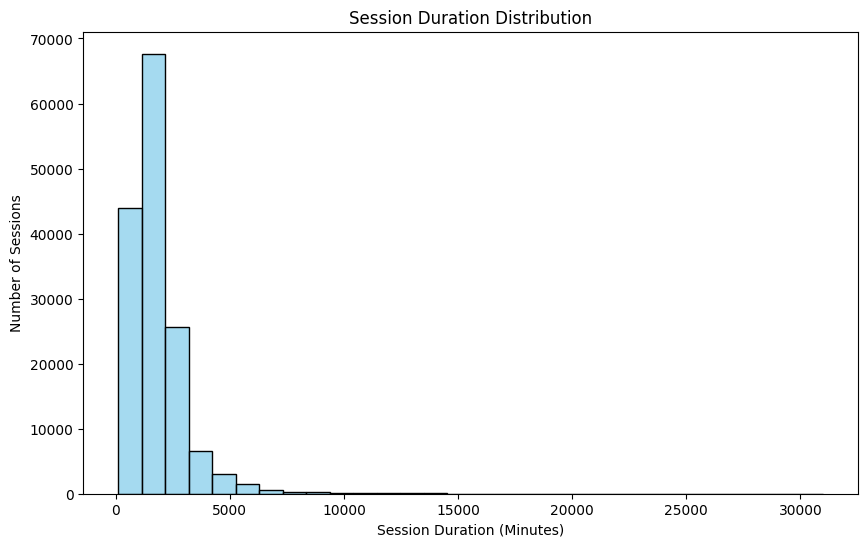

In [81]:

sessions_df = df[['MSISDN/Number', 'Start', 'End']]

# Convert 'Start' and 'End' columns to datetime format
sessions_df['Start'] = pd.to_datetime(sessions_df['Start'])
sessions_df['End'] = pd.to_datetime(sessions_df['End'])

# Calculate session duration in minutes
sessions_df['Session_Duration_Minutes'] = (sessions_df['End'] - sessions_df['Start']).dt.total_seconds() / 60

# Display the session duration for each session
print(sessions_df[['MSISDN/Number', 'Session_Duration_Minutes']])

# Create a histogram to visualize the distribution of session durations
plt.figure(figsize=(10, 6))
sns.histplot(sessions_df['Session_Duration_Minutes'], bins=30, kde=False, color='skyblue')
plt.title('Session Duration Distribution')
plt.xlabel('Session Duration (Minutes)')
plt.ylabel('Number of Sessions')
plt.show()

## Total Traffic Distribution

        MSISDN/Number  Total_Traffic_Bytes
0        3.366496e+10         3.456294e+08
1        3.368185e+10         7.071854e+08
2        3.376063e+10         3.076910e+08
3        3.375034e+10         8.893527e+08
4        3.369980e+10         6.076814e+08
...               ...                  ...
149996   3.365069e+10         6.318041e+08
149997   3.366345e+10         7.057839e+08
149998   3.362189e+10         6.276986e+08
149999   3.361962e+10         4.015220e+08
150000   4.188282e+10         4.957646e+08

[150001 rows x 2 columns]


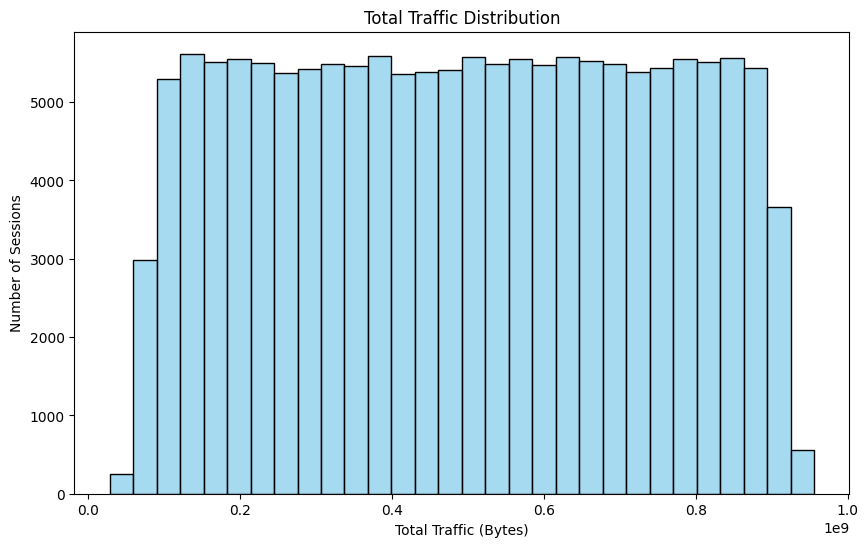

In [86]:

sessions_df = df_clean[['MSISDN/Number', 'Total DL (Bytes)', 'Total UL (Bytes)']]

# Calculate the total traffic (download + upload) for each session
sessions_df['Total_Traffic_Bytes'] = sessions_df['Total DL (Bytes)'] + sessions_df['Total UL (Bytes)']

# Display the total traffic for each session
print(sessions_df[['MSISDN/Number', 'Total_Traffic_Bytes']])

# Create a histogram to visualize the distribution of total traffic
plt.figure(figsize=(10, 6))
sns.histplot(sessions_df['Total_Traffic_Bytes'], bins=30, kde=False, color='skyblue')
plt.title('Total Traffic Distribution')
plt.xlabel('Total Traffic (Bytes)')
plt.ylabel('Number of Sessions')
plt.show()

## Task 3.1

## top 10 customers per engagement metric 

In [93]:

engagement_metrics_df = df_clean[['MSISDN/Number', 'Total DL (Bytes)', 'Total UL (Bytes)', 'Start', 'End']]

# Convert 'Start' and 'End' columns to datetime format
engagement_metrics_df['Start'] = pd.to_datetime(engagement_metrics_df['Start'])
engagement_metrics_df['End'] = pd.to_datetime(engagement_metrics_df['End'])

# Calculate session duration in minutes
engagement_metrics_df['Session_Duration_Minutes'] = (engagement_metrics_df['End'] - engagement_metrics_df['Start']).dt.total_seconds() / 60

# Group by MSISDN and calculate the sum of engagement metrics
aggregated_metrics = engagement_metrics_df.groupby('MSISDN/Number').agg({
    'Total DL (Bytes)': 'sum',
    'Total UL (Bytes)': 'sum',
    'Session_Duration_Minutes': 'sum'
}).reset_index()

# Display the aggregated metrics
print(aggregated_metrics)

# Report the top 10 customers for each engagement metric
top_10_dl_customers = aggregated_metrics.nlargest(10, 'Total DL (Bytes)')[['MSISDN/Number', 'Total DL (Bytes)']]
top_10_ul_customers = aggregated_metrics.nlargest(10, 'Total UL (Bytes)')[['MSISDN/Number', 'Total UL (Bytes)']]
top_10_duration_customers = aggregated_metrics.nlargest(10, 'Session_Duration_Minutes')[['MSISDN/Number', 'Session_Duration_Minutes']]

# Display the top 10 customers for each engagement metric
print("Top 10 Customers by Total DL (Bytes):")
print(top_10_dl_customers)

print("\nTop 10 Customers by Total UL (Bytes):")
print(top_10_ul_customers)

print("\nTop 10 Customers by Session Duration (Minutes):")
print(top_10_duration_customers)

        MSISDN/Number  Total DL (Bytes)  Total UL (Bytes)  \
0        3.360100e+10      8.426375e+08      3.605311e+07   
1        3.360100e+10      1.207552e+08      3.610446e+07   
2        3.360100e+10      5.566597e+08      3.930682e+07   
3        3.360101e+10      4.019932e+08      2.032753e+07   
4        3.360101e+10      1.363130e+09      9.428053e+07   
...               ...               ...               ...   
106852   3.379000e+10      4.445751e+08      3.573224e+07   
106853   4.188282e+10      4.873783e+11      4.436642e+10   
106854   3.197021e+12      1.948281e+08      3.729592e+07   
106855   3.370000e+14      5.396350e+08      5.665284e+07   
106856   8.823971e+14      7.869760e+07      6.045605e+07   

        Session_Duration_Minutes  
0                         1946.0  
1                         3021.0  
2                         2250.0  
3                          832.0  
4                          620.0  
...                          ...  
106852                

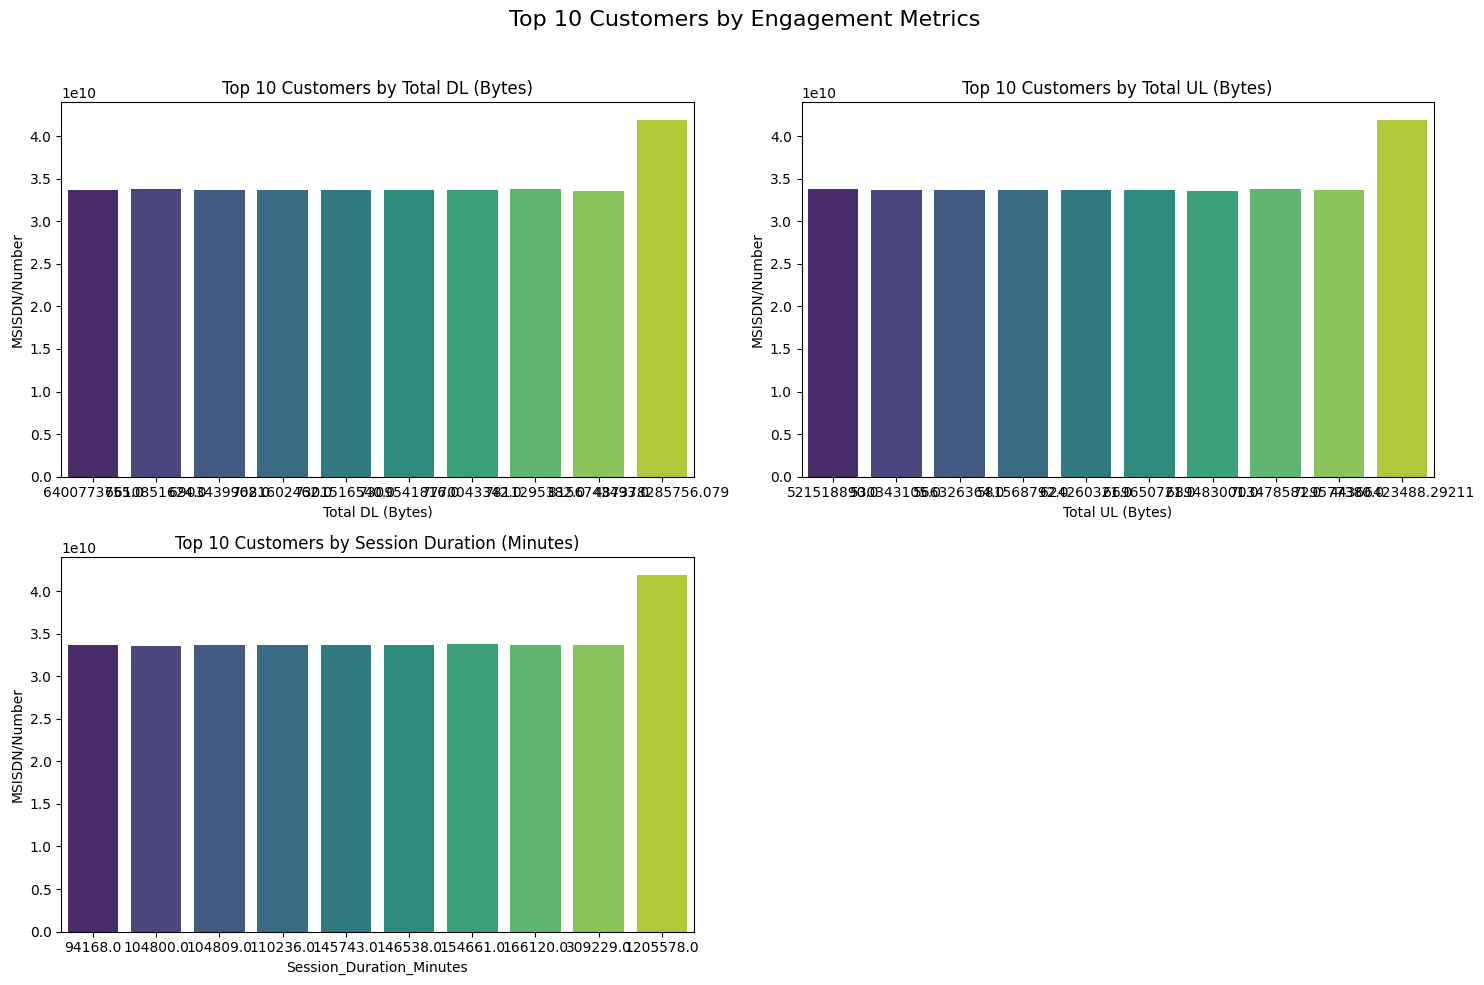

In [94]:
# Set up subplots
fig, axes = plt.subplots(nrows=2, ncols=2, figsize=(15, 10))
fig.suptitle('Top 10 Customers by Engagement Metrics', fontsize=16)

# Bar plot for Top 10 Customers by Total DL (Bytes)
sns.barplot(x='Total DL (Bytes)', y='MSISDN/Number', data=top_10_dl_customers, ax=axes[0, 0], palette='viridis')
axes[0, 0].set_title('Top 10 Customers by Total DL (Bytes)')

# Bar plot for Top 10 Customers by Total UL (Bytes)
sns.barplot(x='Total UL (Bytes)', y='MSISDN/Number', data=top_10_ul_customers, ax=axes[0, 1], palette='viridis')
axes[0, 1].set_title('Top 10 Customers by Total UL (Bytes)')

# Bar plot for Top 10 Customers by Session Duration (Minutes)
sns.barplot(x='Session_Duration_Minutes', y='MSISDN/Number', data=top_10_duration_customers, ax=axes[1, 0], palette='viridis')
axes[1, 0].set_title('Top 10 Customers by Session Duration (Minutes)')

# Remove empty subplot
fig.delaxes(axes[1, 1])

plt.tight_layout(rect=[0, 0, 1, 0.96])  # Adjust subplot layout
plt.show()

## Normalize the engagement metrics

        MSISDN/Number  Cluster
0        3.366496e+10        0
1        3.368185e+10        0
2        3.376063e+10        0
3        3.375034e+10        0
4        3.369980e+10        0
...               ...      ...
149996   3.365069e+10        2
149997   3.366345e+10        2
149998   3.362189e+10        2
149999   3.361962e+10        1
150000   4.188282e+10        2

[150001 rows x 2 columns]


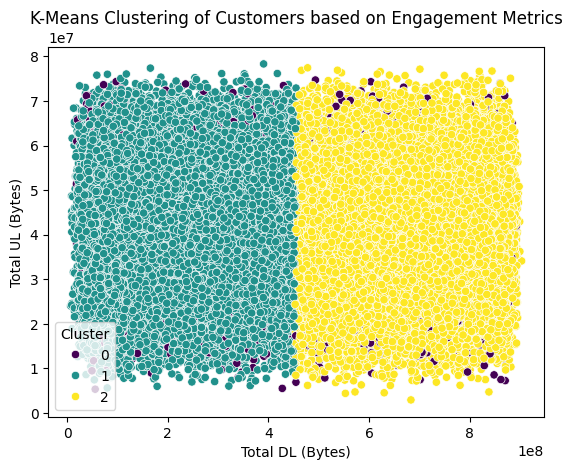

In [98]:
engagement_metrics_df = engagement_metrics_df[['MSISDN/Number', 'Total DL (Bytes)', 'Total UL (Bytes)', 'Session_Duration_Minutes']]

# Normalize the engagement metrics
scaler = StandardScaler()
normalized_metrics = scaler.fit_transform(engagement_metrics_df.drop('MSISDN/Number', axis=1))

# Run k-means clustering with k=3
kmeans = KMeans(n_clusters=3, random_state=42)
engagement_metrics_df['Cluster'] = kmeans.fit_predict(normalized_metrics)

# Display the cluster assignments
print(engagement_metrics_df[['MSISDN/Number', 'Cluster']])

# Visualize the clusters
sns.scatterplot(x='Total DL (Bytes)', y='Total UL (Bytes)', hue='Cluster', data=engagement_metrics_df, palette='viridis')
plt.title('K-Means Clustering of Customers based on Engagement Metrics')
plt.xlabel('Total DL (Bytes)')
plt.ylabel('Total UL (Bytes)')
plt.show()

## Compute the minimum, maximum, average & total non-normalized metrics for each cluster

  Cluster Total DL (Bytes)                                           \
                       min          max          mean           sum   
0       0      597420075.0  902969616.0  7.371311e+08  3.662952e+13   
1       1        7114041.0  315394420.0  1.731594e+08  8.697449e+12   
2       2      315399139.0  597401931.0  4.566603e+08  2.287000e+13   

  Total UL (Bytes)                                          \
               min         max          mean           sum   
0        2866892.0  77157382.0  4.111731e+07  2.043201e+12   
1        5276726.0  77390291.0  4.117853e+07  2.068315e+12   
2        4338786.0  78331311.0  4.106758e+07  2.056706e+12   

  Session_Duration_Minutes                                    
                       min      max         mean         sum  
0                    119.0  30989.0  1741.552302  86541217.0  
1                    120.0  30989.0  1742.915903  87543180.0  
2                  -1884.0  29549.0  1745.900341  87436435.0  


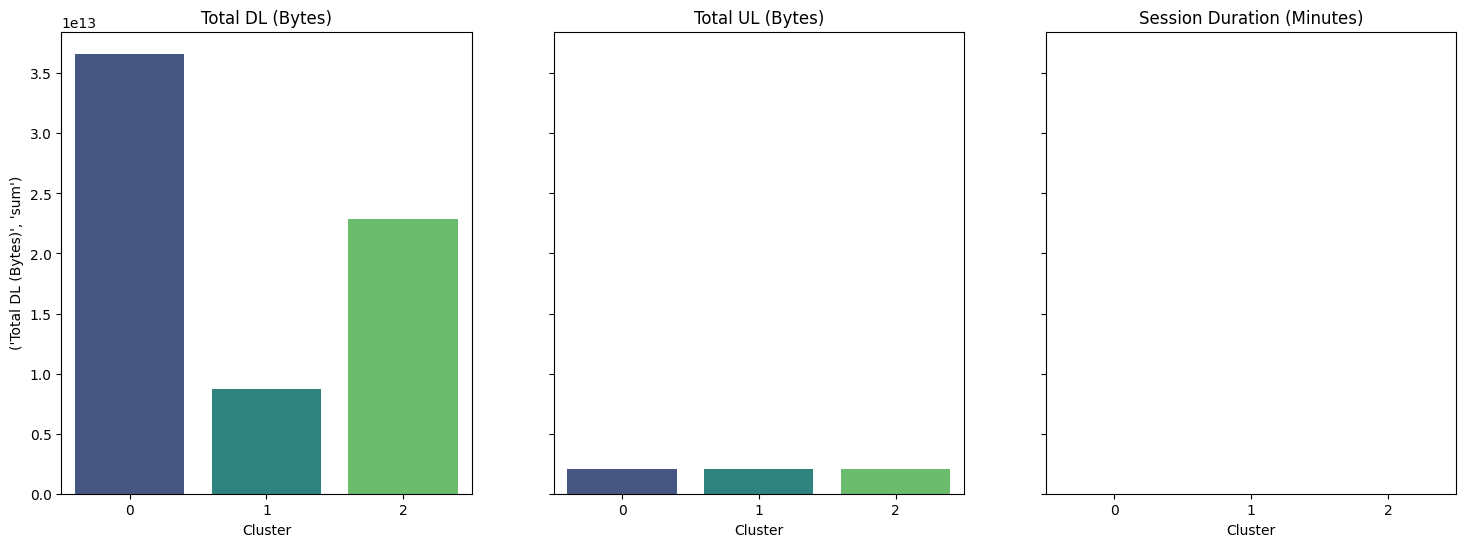

In [99]:
engagement_metrics_df = engagement_metrics_df[['MSISDN/Number', 'Total DL (Bytes)', 'Total UL (Bytes)', 'Session_Duration_Minutes']]

# Add the cluster assignments to the DataFrame
engagement_metrics_df['Cluster'] = kmeans.fit_predict(engagement_metrics_df.drop('MSISDN/Number', axis=1))

# Group by Cluster and calculate the minimum, maximum, average, and total metrics
cluster_metrics_summary = engagement_metrics_df.groupby('Cluster').agg({
    'Total DL (Bytes)': ['min', 'max', 'mean', 'sum'],
    'Total UL (Bytes)': ['min', 'max', 'mean', 'sum'],
    'Session_Duration_Minutes': ['min', 'max', 'mean', 'sum']
}).reset_index()

# Display the summary
print(cluster_metrics_summary)

# Visualize the results
fig, axes = plt.subplots(nrows=1, ncols=3, figsize=(18, 6), sharey=True)

# Total DL (Bytes)
sns.barplot(x='Cluster', y=('Total DL (Bytes)', 'sum'), data=cluster_metrics_summary, ax=axes[0], palette='viridis')
axes[0].set_title('Total DL (Bytes)')

# Total UL (Bytes)
sns.barplot(x='Cluster', y=('Total UL (Bytes)', 'sum'), data=cluster_metrics_summary, ax=axes[1], palette='viridis')
axes[1].set_title('Total UL (Bytes)')

# Session Duration (Minutes)
sns.barplot(x='Cluster', y=('Session_Duration_Minutes', 'sum'), data=cluster_metrics_summary, ax=axes[2], palette='viridis')
axes[2].set_title('Session Duration (Minutes)')

plt.show()


## Aggregate user total traffic per application and derive the top 10 most engaged users per application

In [102]:
application_columns = ['Social Media', 'Google', 'Email', 'Youtube', 'Netflix', 'Gaming', 'Other']

# Create a new DataFrame for application data
application_df = df_clean[['MSISDN/Number'] + [f'{app} DL (Bytes)' for app in application_columns] + [f'{app} UL (Bytes)' for app in application_columns]]

# Calculate total traffic per application for each user
for app in application_columns:
    application_df[f'{app} Total Traffic (Bytes)'] = application_df[f'{app} DL (Bytes)'] + application_df[f'{app} UL (Bytes)']

# Aggregate total traffic per application for each user
user_total_traffic_per_app = application_df.groupby('MSISDN/Number')[[f'{app} Total Traffic (Bytes)' for app in application_columns]].sum().reset_index()

# Display the aggregated total traffic per application
print(user_total_traffic_per_app)

# Derive the top 10 most engaged users per application
top_10_users_per_app = pd.DataFrame(columns=['Application', 'MSISDN/Number', 'Total Traffic (Bytes)'])

for app in application_columns:
    top_10_users = user_total_traffic_per_app.nlargest(10, f'{app} Total Traffic (Bytes)')[['MSISDN/Number', f'{app} Total Traffic (Bytes)']]
    top_10_users.rename(columns={f'{app} Total Traffic (Bytes)': 'Total Traffic (Bytes)'}, inplace=True)
    top_10_users['Application'] = app
    top_10_users_per_app = pd.concat([top_10_users_per_app, top_10_users])

# Display the top 10 most engaged users per application
print(top_10_users_per_app)


        MSISDN/Number  Social Media Total Traffic (Bytes)  \
0        3.360100e+10                        2.232135e+06   
1        3.360100e+10                        2.660565e+06   
2        3.360100e+10                        3.195623e+06   
3        3.360101e+10                        2.802940e+05   
4        3.360101e+10                        2.912542e+06   
...               ...                                 ...   
106852   3.379000e+10                        4.985690e+05   
106853   4.188282e+10                        1.973817e+09   
106854   3.197021e+12                        7.152240e+05   
106855   3.370000e+14                        5.215660e+05   
106856   8.823971e+14                        1.546088e+06   

        Google Total Traffic (Bytes)  Email Total Traffic (Bytes)  \
0                       4.389005e+06                 1.331362e+06   
1                       5.334863e+06                 3.307781e+06   
2                       3.443126e+06                 3.20538

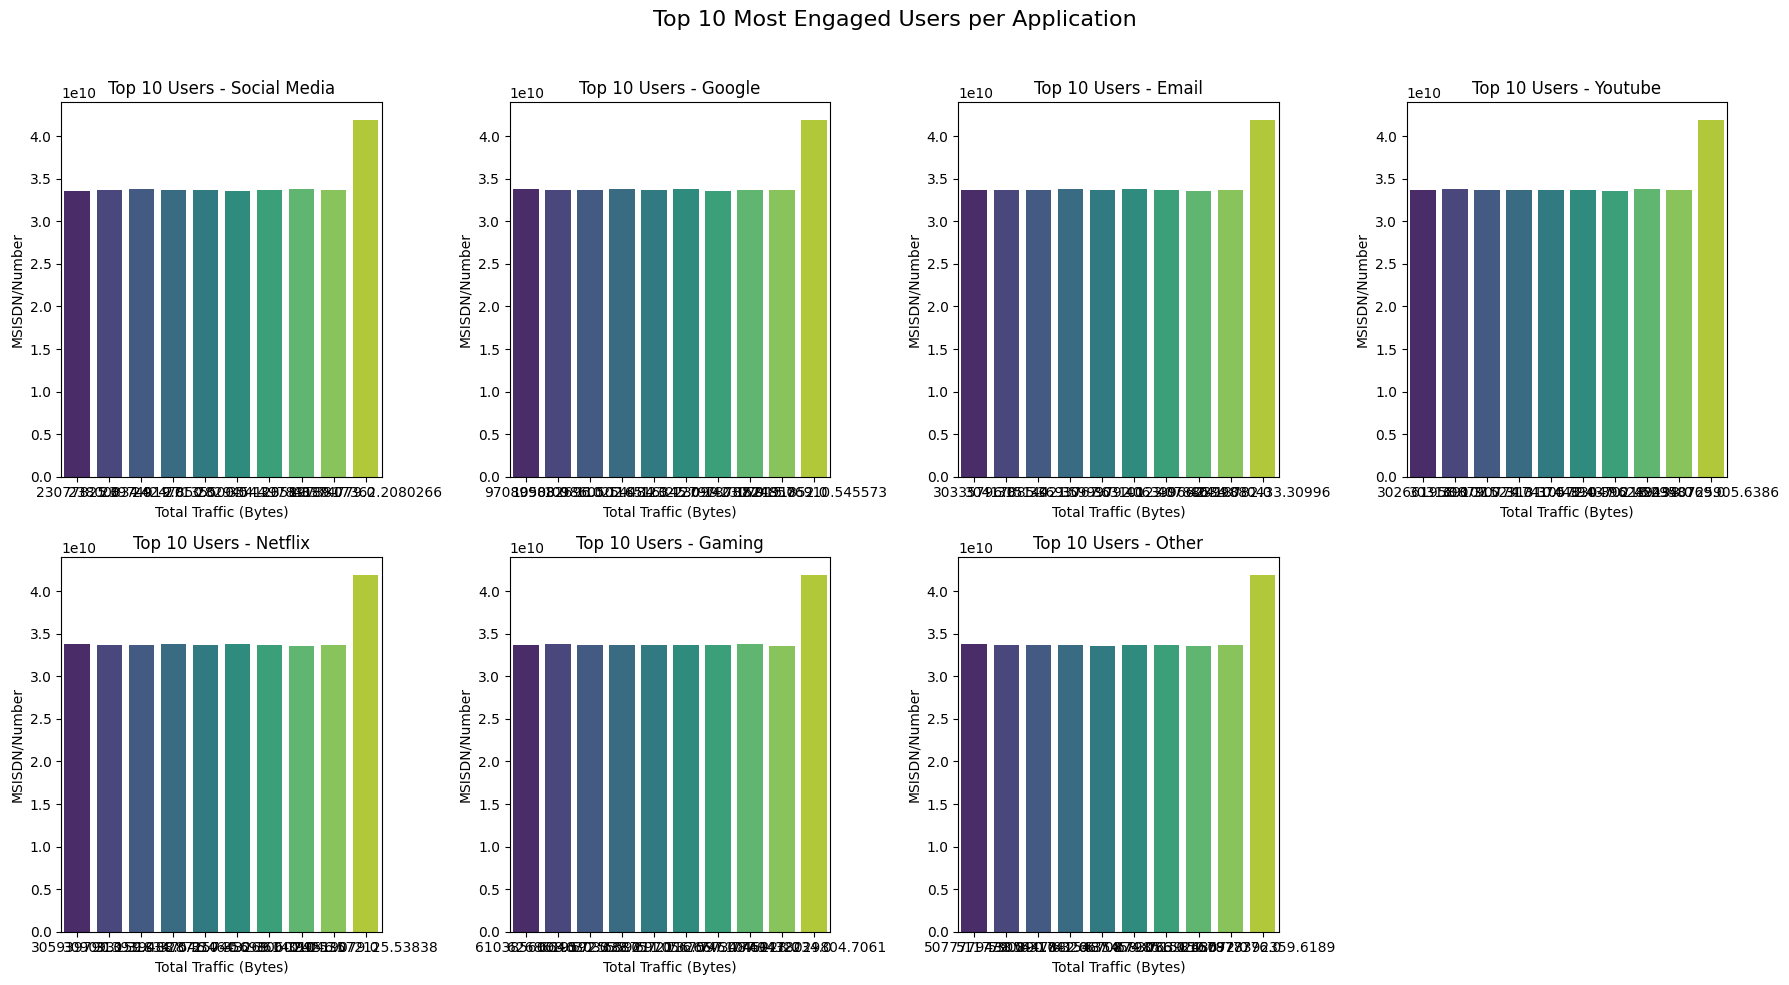

In [103]:
# Set up subplots
fig, axes = plt.subplots(nrows=2, ncols=4, figsize=(18, 10))
fig.suptitle('Top 10 Most Engaged Users per Application', fontsize=16)

# Iterate through each application and plot the top 10 users
for i, app in enumerate(application_columns):
    top_10_users = top_10_users_per_app[top_10_users_per_app['Application'] == app]
    sns.barplot(x='Total Traffic (Bytes)', y='MSISDN/Number', data=top_10_users, ax=axes[i // 4, i % 4], palette='viridis')
    axes[i // 4, i % 4].set_title(f'Top 10 Users - {app}')
    axes[i // 4, i % 4].set_xlabel('Total Traffic (Bytes)')
    axes[i // 4, i % 4].set_ylabel('MSISDN/Number')

# Remove empty subplots if necessary
for i in range(len(application_columns), len(axes.flat)):
    fig.delaxes(axes.flatten()[i])

plt.tight_layout(rect=[0, 0, 1, 0.96])  # Adjust subplot layout
plt.show()

## Plot the top 3 most used applications using appropriate charts. 

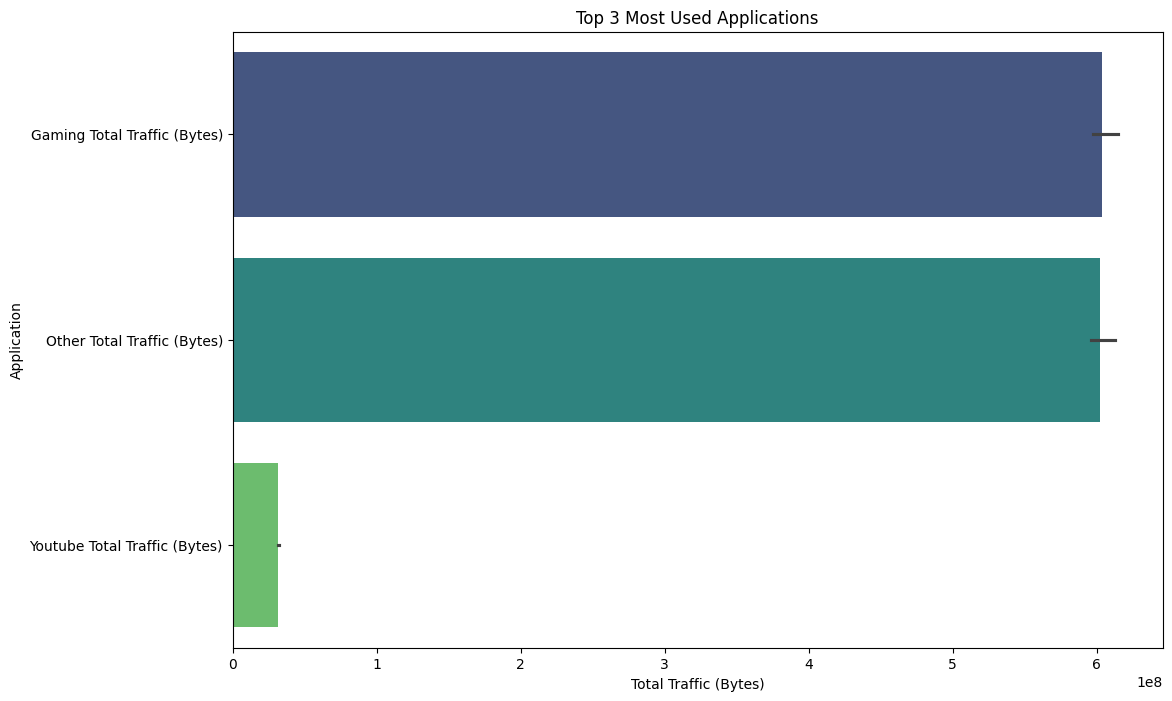

In [104]:
# Calculate total traffic across all applications for each user
user_total_traffic_per_app['Total Traffic (Bytes)'] = user_total_traffic_per_app.sum(axis=1)

# Get the top 3 most used applications
top_3_applications = user_total_traffic_per_app.iloc[:, 1:-1].sum().nlargest(3).index

# Create a DataFrame for the top 3 applications
top_3_df = user_total_traffic_per_app[['MSISDN/Number'] + list(top_3_applications)]

# Melt the DataFrame for easier plotting
top_3_melted = top_3_df.melt(id_vars='MSISDN/Number', var_name='Application', value_name='Total Traffic (Bytes)')

# Plot the top 3 most used applications
plt.figure(figsize=(12, 8))
sns.barplot(x='Total Traffic (Bytes)', y='Application', data=top_3_melted, palette='viridis')
plt.title('Top 3 Most Used Applications')
plt.xlabel('Total Traffic (Bytes)')
plt.ylabel('Application')
plt.show()

## Group users in k engagement clusters based on the engagement metrics

In [108]:
# 'MSISDN/Number' is the column containing user identifiers
# and columns like 'Total DL (Bytes)', 'Total UL (Bytes)', 'Session_Duration_Minutes' represent the engagement metrics
engagement_metrics_df = engagement_metrics_df[['MSISDN/Number', 'Total DL (Bytes)', 'Total UL (Bytes)', 'Session_Duration_Minutes']]

# Normalize the engagement metrics
scaler = StandardScaler()
normalized_metrics = scaler.fit_transform(engagement_metrics_df.drop('MSISDN/Number', axis=1))

# Determine the optimal k using the elbow method
sse = []
silhouette_scores = []
possible_k_values = range(2, 11)  # You can adjust this range based on your dataset

for k in possible_k_values:
    kmeans = KMeans(n_clusters=k, random_state=42)
    kmeans.fit(normalized_metrics)
    sse.append(kmeans.inertia_)
    silhouette_scores.append(silhouette_score(normalized_metrics, kmeans.labels_))

# Plot the elbow method graph
plt.figure(figsize=(12, 6))

# Plot SSE (Sum of Squared Errors) on the left y-axis
plt.subplot(1, 2, 1)
plt.plot(possible_k_values, sse, marker='o')
plt.title('Elbow Method - SSE')
plt.xlabel('Number of Clusters (k)')
plt.ylabel('SSE')

# Plot Silhouette Score on the right y-axis
plt.subplot(1, 2, 2)
plt.plot(possible_k_values, silhouette_scores, marker='o', color='orange')
plt.title('Elbow Method - Silhouette Score')
plt.xlabel('Number of Clusters (k)')
plt.ylabel('Silhouette Score')

plt.tight_layout()
plt.show()

KeyboardInterrupt: 

## Interpretation:
 
- The top principal components, particularly PC1 and PC2, highlight patterns in the usage of different applications and the overall session duration.
- PC1 captures variations in the total data usage, especially in terms of session duration and total download/upload data.
- PC2 captures patterns related to specific applications, such as social media, Google, YouTube, and gaming.
nents.

## Recommendation:
 
- Marketing teams can focus on optimizing user experiences for applications influencing PC1 and PC2.
- Tailor promotional strategies for users with specific patterns identified by the principal components.



In [5]:
df.head()

Bearer Id            Start  Start ms              End  End ms  \
0  1.311448e+19   4/4/2019 12:01     770.0  4/25/2019 14:35   662.0   
1  1.311448e+19   4/9/2019 13:04     235.0   4/25/2019 8:15   606.0   
2  1.311448e+19   4/9/2019 17:42       1.0  4/25/2019 11:58   652.0   
3  1.311448e+19   4/10/2019 0:31     486.0   4/25/2019 7:36   171.0   
4  1.311448e+19  4/12/2019 20:10     565.0  4/25/2019 10:40   954.0   

   Dur. (ms)          IMSI  MSISDN/Number          IMEI  \
0  1823652.0  2.082014e+14   3.366496e+10  3.552121e+13   
1  1365104.0  2.082019e+14   3.368185e+10  3.579401e+13   
2  1361762.0  2.082003e+14   3.376063e+10  3.528151e+13   
3  1321509.0  2.082014e+14   3.375034e+10  3.535661e+13   
4  1089009.0  2.082014e+14   3.369980e+10  3.540701e+13   

      Last Location Name  ...  Youtube DL (Bytes)  Youtube UL (Bytes)  \
0  9.16456699548519E+015  ...          15854611.0           2501332.0   
1                L77566A  ...          20247395.0          19111729.0   
2                D42335A  ...          19725661.0          14699576.0   
3                T21824A  ...          21388122.0          15146643.0   
4                D88865A  ...          15259380.0          18962873.0   

   Netflix DL (Bytes)  Netflix UL (Bytes)  Gaming DL (Bytes)  \
0           8198936.0           9656251.0        278082303.0   
1          18338413.0          17227132.0        608750074.0   
2          17587794.0           6163408.0        229584621.0   
3          13994646.0           1097942.0        799538153.0   
4          17124581.0            415218.0        527707248.0   

   Gaming UL (Bytes)  Other DL (Bytes)  Other UL (Bytes)  Total UL (Bytes)  \
0         14344150.0       171744450.0         8814393.0        36749741.0   
1          1170709.0       526904238.0        15055145.0        53800391.0   
2           395630.0       410692588.0         4215763.0        27883638.0   
3         10849722.0       749039933.0        12797283.0        43324218.0   
4          3529801.0       550709500.0        13910322.0        38542814.0   

   Total DL (Bytes)  
0       308879636.0  
1       653384965.0  
2       279807335.0  
3       846028530.0  
4       569138589.0  

[5 rows x 55 columns]

In [6]:
df.shape

(150001, 55)

In [7]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 150001 entries, 0 to 150000
Data columns (total 55 columns):
 #   Column                                    Non-Null Count   Dtype  
---  ------                                    --------------   -----  
 0   Bearer Id                                 149010 non-null  float64
 1   Start                                     150000 non-null  object 
 2   Start ms                                  150000 non-null  float64
 3   End                                       150000 non-null  object 
 4   End ms                                    150000 non-null  float64
 5   Dur. (ms)                                 150000 non-null  float64
 6   IMSI                                      149431 non-null  float64
 7   MSISDN/Number                             148935 non-null  float64
 8   IMEI                                      149429 non-null  float64
 9   Last Location Name                        148848 non-null  object 
 10  Avg RTT DL (ms)     

In [8]:
# Step 1: Display the count of null values in each column
null_counts = df.isnull().sum()

# Step 2: Calculate the percentage of null values in each column
total_rows = df.shape[0]
null_percentage = (null_counts / total_rows) * 100

# Step 3: Create a new DataFrame to display the results
null_info = pd.DataFrame({
    'Column': null_counts.index,
    'Null Count': null_counts.values,
    'Null Percentage': null_percentage.values
})

# Step 4: Display the information
print(null_info)

                                      Column  Null Count  Null Percentage
0                                  Bearer Id         991         0.660662
1                                      Start           1         0.000667
2                                   Start ms           1         0.000667
3                                        End           1         0.000667
4                                     End ms           1         0.000667
5                                  Dur. (ms)           1         0.000667
6                                       IMSI         570         0.379997
7                              MSISDN/Number        1066         0.710662
8                                       IMEI         572         0.381331
9                         Last Location Name        1153         0.768662
10                           Avg RTT DL (ms)       27829        18.552543
11                           Avg RTT UL (ms)       27812        18.541210
12                   Avg Bearer TP DL 

In [4]:
# Calculate null percentages
null_counts = df.isnull().sum()
total_rows = df.shape[0]
null_percentage = (null_counts / total_rows) * 100

# Create a mask for columns with null_percentage <= 0.5
mask = null_percentage <= 0.5

# Filter the DataFrame to keep only columns with null_percentage <= 0.5
df_filtered = df.loc[:, mask]

# Display the filtered DataFrame
df_filtered.head()

Start  Start ms              End  End ms  Dur. (ms)  \
0   4/4/2019 12:01     770.0  4/25/2019 14:35   662.0  1823652.0   
1   4/9/2019 13:04     235.0   4/25/2019 8:15   606.0  1365104.0   
2   4/9/2019 17:42       1.0  4/25/2019 11:58   652.0  1361762.0   
3   4/10/2019 0:31     486.0   4/25/2019 7:36   171.0  1321509.0   
4  4/12/2019 20:10     565.0  4/25/2019 10:40   954.0  1089009.0   

           IMSI          IMEI  Avg Bearer TP DL (kbps)  \
0  2.082014e+14  3.552121e+13                     23.0   
1  2.082019e+14  3.579401e+13                     16.0   
2  2.082003e+14  3.528151e+13                      6.0   
3  2.082014e+14  3.535661e+13                     44.0   
4  2.082014e+14  3.540701e+13                      6.0   

   Avg Bearer TP UL (kbps)  Activity Duration DL (ms)  ...  \
0                     44.0                    37624.0  ...   
1                     26.0                      168.0  ...   
2                      9.0                        0.0  ...   
3                     44.0                     3330.0  ...   
4                      9.0                        0.0  ...   

   Youtube DL (Bytes)  Youtube UL (Bytes) Netflix DL (Bytes)  \
0          15854611.0           2501332.0          8198936.0   
1          20247395.0          19111729.0         18338413.0   
2          19725661.0          14699576.0         17587794.0   
3          21388122.0          15146643.0         13994646.0   
4          15259380.0          18962873.0         17124581.0   

  Netflix UL (Bytes)  Gaming DL (Bytes)  Gaming UL (Bytes)  Other DL (Bytes)  \
0          9656251.0        278082303.0         14344150.0       171744450.0   
1         17227132.0        608750074.0          1170709.0       526904238.0   
2          6163408.0        229584621.0           395630.0       410692588.0   
3          1097942.0        799538153.0         10849722.0       749039933.0   
4           415218.0        527707248.0          3529801.0       550709500.0   

   Other UL (Bytes)  Total UL (Bytes)  Total DL (Bytes)  
0         8814393.0        36749741.0       308879636.0  
1        15055145.0        53800391.0       653384965.0  
2         4215763.0        27883638.0       279807335.0  
3        12797283.0        43324218.0       846028530.0  
4        13910322.0        38542814.0       569138589.0  

[5 rows x 30 columns]

In [10]:
df_filtered.shape

(150001, 30)

In [11]:
df_filtered.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 150001 entries, 0 to 150000
Data columns (total 30 columns):
 #   Column                     Non-Null Count   Dtype  
---  ------                     --------------   -----  
 0   Start                      150000 non-null  object 
 1   Start ms                   150000 non-null  float64
 2   End                        150000 non-null  object 
 3   End ms                     150000 non-null  float64
 4   Dur. (ms)                  150000 non-null  float64
 5   IMSI                       149431 non-null  float64
 6   IMEI                       149429 non-null  float64
 7   Avg Bearer TP DL (kbps)    150000 non-null  float64
 8   Avg Bearer TP UL (kbps)    150000 non-null  float64
 9   Activity Duration DL (ms)  150000 non-null  float64
 10  Activity Duration UL (ms)  150000 non-null  float64
 11  Dur. (ms).1                150000 non-null  float64
 12  Handset Manufacturer       149429 non-null  object 
 13  Handset Type               14

In [11]:
# Display the top 10 handsets used by customers
top_handsets = df_clean['Handset Type'].value_counts().head(10)
print("Top 10 Handsets:")
print(top_handsets)

Top 10 Handsets:
Handset Type
Huawei B528S-23A                20324
Apple iPhone 6S (A1688)          9419
Apple iPhone 6 (A1586)           9023
undefined                        8987
Apple iPhone 7 (A1778)           6326
Apple iPhone Se (A1723)          5187
Apple iPhone 8 (A1905)           4993
Apple iPhone Xr (A2105)          4568
Samsung Galaxy S8 (Sm-G950F)     4520
Apple iPhone X (A1901)           3813
Name: count, dtype: int64


In [12]:

# Display the top 3 handset manufacturers
top_manufacturers = df_clean['Handset Manufacturer'].value_counts().head(3)
print("\nTop 3 Handset Manufacturers:")
print(top_manufacturers)



Top 3 Handset Manufacturers:
Handset Manufacturer
Apple      60137
Samsung    40839
Huawei     34423
Name: count, dtype: int64


In [13]:

# Display the top 5 handsets per top 3 handset manufacturers
top_manufacturer_handsets = df_clean.groupby('Handset Manufacturer')['Handset Type'].value_counts().groupby(level=0, group_keys=False).nlargest(5)
print("\nTop 5 Handsets per Top 3 Manufacturers:")
top_manufacturer_handsets.head()



Top 5 Handsets per Top 3 Manufacturers:


Handset Manufacturer                     Handset Type                    
A-Link Telecom International Co Limited  A-Link Telecom I. Cubot X18 Plus    2
                                         A-Link Telecom I. Cubot A5          1
                                         A-Link Telecom I. Cubot Note S      1
                                         A-Link Telecom I. Cubot Nova        1
                                         A-Link Telecom I. Cubot Power       1
Name: count, dtype: int64

In [11]:
# Interpretation and recommendations
print("\nInterpretation and Recommendations:")
print("1. The top handsets used by customers are:", list(top_handsets.index))
print("2. The top handset manufacturers are:", list(top_manufacturers.index))
print("3. The top 5 handsets per manufacturer provide insights into specific models.")
print("4. Marketing teams can target promotions and advertisements based on popular handsets and manufacturers.")


Interpretation and Recommendations:
1. The top handsets used by customers are: ['Huawei B528S-23A', 'Apple iPhone 6S (A1688)', 'Apple iPhone 6 (A1586)', 'undefined', 'Apple iPhone 7 (A1778)', 'Apple iPhone Se (A1723)', 'Apple iPhone 8 (A1905)', 'Apple iPhone Xr (A2105)', 'Samsung Galaxy S8 (Sm-G950F)', 'Apple iPhone X (A1901)']
2. The top handset manufacturers are: ['Apple', 'Samsung', 'Huawei']
3. The top 5 handsets per manufacturer provide insights into specific models.
4. Marketing teams can target promotions and advertisements based on popular handsets and manufacturers.


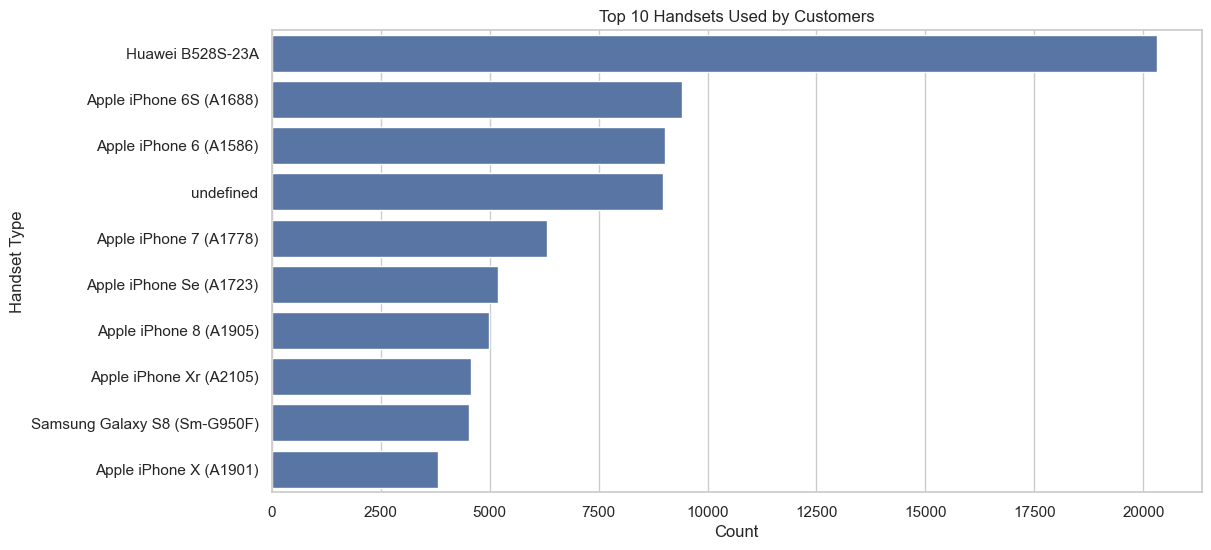

In [14]:
# Set the style for seaborn
sns.set(style="whitegrid")

# Plot the top 10 handsets used by customers
plt.figure(figsize=(12, 6))
sns.countplot(y='Handset Type', data=df_clean, order=df_clean['Handset Type'].value_counts().head(10).index)
plt.title('Top 10 Handsets Used by Customers')
plt.xlabel('Count')
plt.ylabel('Handset Type')
plt.show()

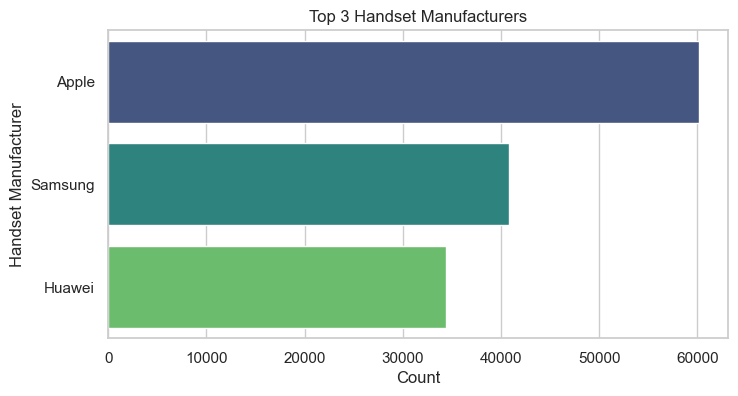

In [15]:
# Plot the top 3 handset manufacturers
plt.figure(figsize=(8, 4))
sns.barplot(x=top_manufacturers.values, y=top_manufacturers.index, palette="viridis")
plt.title('Top 3 Handset Manufacturers')
plt.xlabel('Count')
plt.ylabel('Handset Manufacturer')
plt.show()

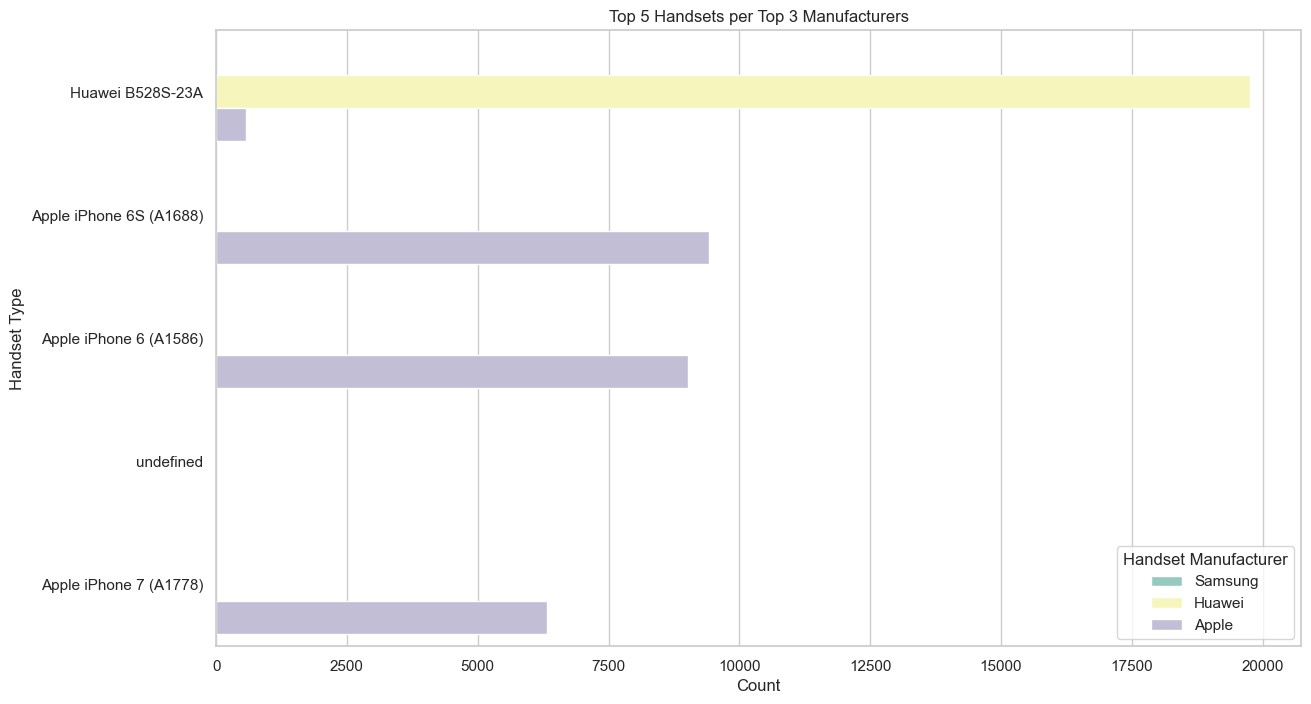

In [20]:
# Plot the top 5 handsets per top 3 handset manufacturers
plt.figure(figsize=(14, 8))
sns.countplot(y='Handset Type', hue='Handset Manufacturer', data=df_clean[df_clean['Handset Manufacturer'].isin(top_manufacturers.index)], order=df_clean['Handset Type'].value_counts().head(5).index, palette="Set3")
plt.title('Top 5 Handsets per Top 3 Manufacturers')
plt.xlabel('Count')
plt.ylabel('Handset Type')
plt.legend(title='Handset Manufacturer', loc='lower right')
plt.show()

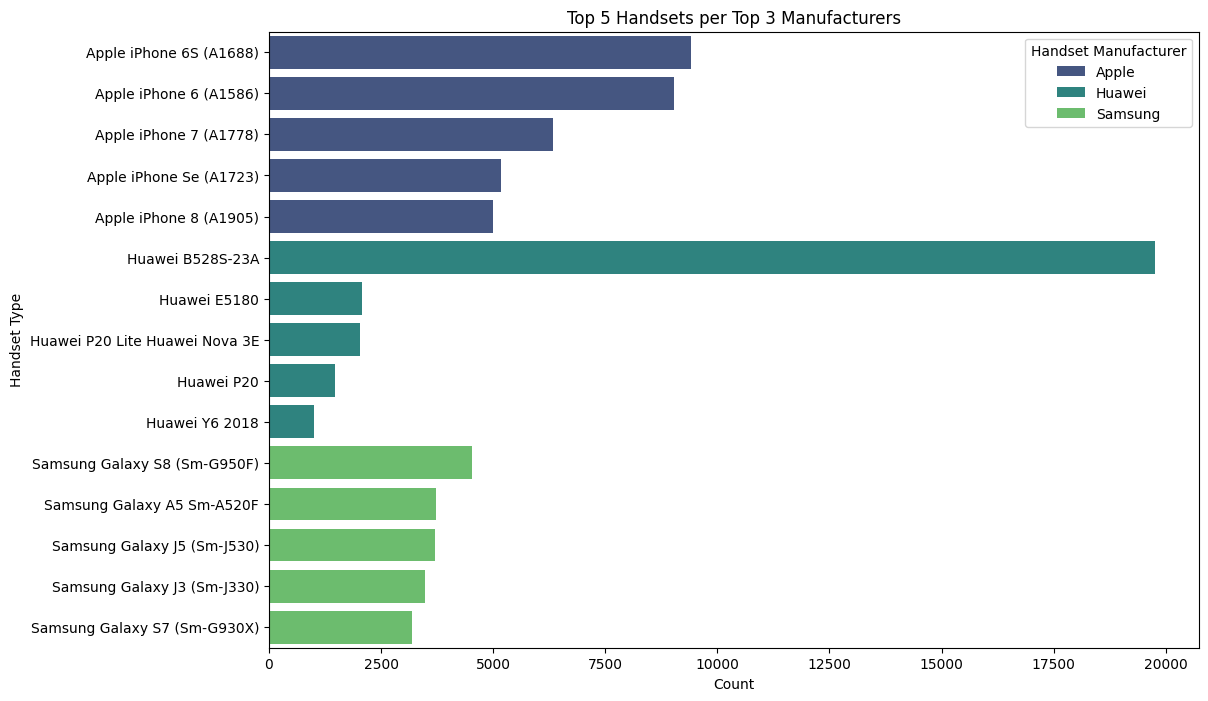

In [113]:
# Assuming 'Handset Manufacturer' and 'Handset Type' are the columns containing manufacturer and handset information
# Replace these with your actual column names

# Create a new DataFrame with 'Handset Manufacturer' and 'Handset Type' columns
handset_df = df_clean[['Handset Manufacturer', 'Handset Type']]

# Group by 'Handset Manufacturer' and 'Handset Type' to count the occurrences
manufacturer_handset_counts = handset_df.groupby(['Handset Manufacturer', 'Handset Type']).size().reset_index(name='Count')

# Get the top 3 manufacturers based on the total count of handsets
top_3_manufacturers = manufacturer_handset_counts.groupby('Handset Manufacturer')['Count'].sum().nlargest(3).index

# Filter the DataFrame to include only the top 3 manufacturers
top_3_manufacturer_handsets = manufacturer_handset_counts[manufacturer_handset_counts['Handset Manufacturer'].isin(top_3_manufacturers)]

# Get the top 5 handsets for each top manufacturer
top_5_handsets_per_manufacturer = top_3_manufacturer_handsets.groupby('Handset Manufacturer').apply(lambda x: x.nlargest(5, 'Count')).reset_index(drop=True)

# Plot the top 5 handsets per top 3 manufacturers
plt.figure(figsize=(12, 8))
sns.barplot(x='Count', y='Handset Type', hue='Handset Manufacturer', data=top_5_handsets_per_manufacturer, palette='viridis')
plt.title('Top 5 Handsets per Top 3 Manufacturers')
plt.xlabel('Count')
plt.ylabel('Handset Type')
plt.show()


In [15]:
user_aggregated = df_clean.groupby('Bearer Id').agg({
    'Bearer Id': 'count',                    # Number of xDR sessions
    'Dur. (ms).1': 'sum',                    # Session duration
    'Total DL (Bytes)': 'sum',               # Total download data
    'Total UL (Bytes)': 'sum',               # Total upload data
    'Social Media DL (Bytes)': 'sum',        # Total social media download data
    'Social Media UL (Bytes)': 'sum',        # Total social media upload data
    'Google DL (Bytes)': 'sum',              # Total Google download data
    'Google UL (Bytes)': 'sum',              # Total Google upload data
    'Email DL (Bytes)': 'sum',               # Total email download data
    'Email UL (Bytes)': 'sum',               # Total email upload data
    'Youtube DL (Bytes)': 'sum',             # Total YouTube download data
    'Youtube UL (Bytes)': 'sum',             # Total YouTube upload data
    'Netflix DL (Bytes)': 'sum',             # Total Netflix download data
    'Netflix UL (Bytes)': 'sum',             # Total Netflix upload data
    'Gaming DL (Bytes)': 'sum',              # Total gaming download data
    'Gaming UL (Bytes)': 'sum',              # Total gaming upload data
    'Other DL (Bytes)': 'sum',               # Total other download data
    'Other UL (Bytes)': 'sum'                # Total other upload data
})

# Rename columns for clarity
user_aggregated = user_aggregated.rename(columns={
    'Bearer Id': 'Number_of_xDR_sessions',
    'Dur. (ms).1': 'Session_duration',
    'Total DL (Bytes)': 'Total_DL_data',
    'Total UL (Bytes)': 'Total_UL_data',
    'Social Media DL (Bytes)': 'Social_Media_DL_data',
    'Social Media UL (Bytes)': 'Social_Media_UL_data',
    'Google DL (Bytes)': 'Google_DL_data',
    'Google UL (Bytes)': 'Google_UL_data',
    'Email DL (Bytes)': 'Email_DL_data',
    'Email UL (Bytes)': 'Email_UL_data',
    'Youtube DL (Bytes)': 'Youtube_DL_data',
    'Youtube UL (Bytes)': 'Youtube_UL_data',
    'Netflix DL (Bytes)': 'Netflix_DL_data',
    'Netflix UL (Bytes)': 'Netflix_UL_data',
    'Gaming DL (Bytes)': 'Gaming_DL_data',
    'Gaming UL (Bytes)': 'Gaming_UL_data',
    'Other DL (Bytes)': 'Other_DL_data',
    'Other UL (Bytes)': 'Other_UL_data'
})

# Display the aggregated information per user
user_aggregated.head()


Number_of_xDR_sessions  Session_duration  Total_DL_data  \
Bearer Id                                                               
6.917538e+18                       1        24534863.0    500721999.0   
6.917538e+18                       1        21489866.0    709549265.0   
6.917538e+18                       1        27786974.0    854465860.0   
6.917538e+18                       1        15635653.0    825786510.0   
6.917538e+18                       1        24264086.0    624957763.0   

              Total_UL_data  Social_Media_DL_data  Social_Media_UL_data  \
Bearer Id                                                                 
6.917538e+18     41704610.0             2404741.0                2410.0   
6.917538e+18     38693596.0             2478607.0               11936.0   
6.917538e+18     15548926.0              944612.0                2827.0   
6.917538e+18     49605688.0             1817239.0               19827.0   
6.917538e+18     21983463.0             1867318.0               18928.0   

              Google_DL_data  Google_UL_data  Email_DL_data  Email_UL_data  \
Bearer Id                                                                    
6.917538e+18       5791591.0       2871336.0       782388.0       806920.0   
6.917538e+18       3605446.0       2825198.0       446376.0       525108.0   
6.917538e+18      10373157.0         56392.0       128003.0        34038.0   
6.917538e+18        269988.0       3696393.0      3191192.0       896670.0   
6.917538e+18       1689296.0        195216.0       740633.0       590043.0   

              Youtube_DL_data  Youtube_UL_data  Netflix_DL_data  \
Bearer Id                                                         
6.917538e+18        6139644.0        2071526.0       19494278.0   
6.917538e+18       10281221.0       18119976.0       19455048.0   
6.917538e+18        5385159.0        4295851.0       15755839.0   
6.917538e+18       12347020.0       11089528.0        2859358.0   
6.917538e+18       15231815.0        8401567.0       21563985.0   

              Netflix_UL_data  Gaming_DL_data  Gaming_UL_data  Other_DL_data  \
Bearer Id                                                                      
6.917538e+18       14668354.0     466109357.0       5333340.0    670751043.0   
6.917538e+18       10631652.0     673282567.0       2670856.0    501608458.0   
6.917538e+18        1300571.0     821879090.0       8521398.0    472846860.0   
6.917538e+18        1738176.0     805301713.0      16257481.0     24303797.0   
6.917538e+18        2817981.0     583864716.0       6992868.0    685122214.0   

              Other_UL_data  
Bearer Id                    
6.917538e+18     15950724.0  
6.917538e+18      3908870.0  
6.917538e+18      1337849.0  
6.917538e+18     15907613.0  
6.917538e+18      2966860.0